In [505]:
import pandas as pd
import requests
import bs4
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import tqdm

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [799]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [800]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

In [801]:
# Let's look at a single example from the slider_container tag
slider = soup.find_all('div', class_='slider_container')
slider

[<div class="slider_container"><div class="slider_list"><div class="slider_item"><div class="job_seen_beacon"><table cellpadding="0" cellspacing="0" class="jobCard_mainContent big6_visualChanges" role="presentation"><tbody><tr><td class="resultContent"><div class="heading4 color-text-primary singleLineTitle tapItem-gutter"><h2 class="jobTitle jobTitle-color-purple"><span title="Data Scientist, Affordable Electrification">Data Scientist, Affordable Electrification</span></h2></div><div class="heading6 company_location tapItem-gutter"><pre><span class="companyName">Sidewalk Labs</span><div class="companyLocation">New York, NY<!-- --> <!-- -->10001<!-- --> <span class="companyLocation--extras">(<!-- -->Chelsea area<!-- -->)</span></div></pre></div><div class="heading6 error-text tapItem-gutter"></div></td></tr></tbody></table><table class="jobCardShelfContainer big6_visualChanges" role="presentation"><tbody><tr class="jobCardShelf"></tr><tr class="underShelfFooter"><td><div class="heading

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [512]:
def extract_job_title_from_result(soup):
    
    title_list = []
    
    html = soup.find_all('td', class_='resultContent')
    
    for element in html:
    
        try:
            title_list.append(element.find('h2', {'class' : 'jobTitle jobTitle-color-purple'}).text.strip())
            
        except:
            title_list.append('no job title')
            
    return title_list

In [513]:
extract_job_title_from_result(soup)

['Sports Statistician',
 'no job title',
 'Senior Data Scientist',
 'Data Scientist, Affordable Electrification',
 'Data Scientist',
 'no job title',
 'Entry Level - Associate Data Scientist (Commercial)',
 'Junior Data Scientist',
 'Data Scientist',
 'no job title',
 'Data Scientist-Spanish Language',
 'no job title',
 'no job title',
 'no job title',
 'Data Scientist']

In [514]:
def extract_location_from_result(soup):
    
    location_list = []
    
    html = soup.find_all('td', class_= 'resultContent')
    
    for element in html:
        
        try:
            location_list.append(element.find('div', {'class' : 'companyLocation'}).text.strip())
            
        except:
            location_list.append('no location')

        
    return location_list

In [515]:
extract_location_from_result(soup)

['New York, NY+1 location',
 'New York, NY+1 location•Remote',
 'Corning, NY 14831',
 'New York, NY 10001 (Chelsea area)',
 'New York State•Remote',
 'New York, NY+2 locations',
 'New York, NY 10001 (Chelsea area)',
 'New York, NY 10017 (Turtle Bay area)',
 'New York, NY 10017 (Turtle Bay area)+1 location',
 'New York, NY+1 location',
 'New York, NY 10010 (Flatiron District area)+3 locations',
 'New York, NY 10020 (Midtown area)',
 'New York, NY',
 'New York, NY 10119 (Chelsea area)+1 location',
 'New York, NY+6 locations']

In [516]:
def extract_company_from_result(soup):
    
    company_list = []
    
    html = soup.find_all('td', class_= 'resultContent')
    
    for element in html:
        
        try:
            company_list.append(element.find('span', {'class' : 'companyName'}).text.strip())
            
        except:
            company_list.append('no company name')

        
    return company_list

In [517]:
extract_company_from_result(soup)

['Life Time',
 'VMware',
 'Corning',
 'Sidewalk Labs',
 'Garner Health',
 'Veeva Systems',
 'IBM',
 'Reonomy',
 'Memorial Sloan-Kettering Cancer Center',
 'Quizlet',
 'Kasisto',
 'AllianceBernstein',
 'CANDY',
 'Presidio',
 'Two Sigma Investments, LLC.']

In [812]:
# when I came to do further scraping of indeed the salary tag did change

def extract_salary_from_result(soup):
    
    salary_list = []
    
    html = soup.find_all('div', class_='slider_container')
    
    for element in html:
        
        try:
            salary_list.append(element.find('div', class_='attribute_snippet').text.strip())
            
        except:
            salary_list.append('no salary given')

        
    return salary_list

In [813]:
extract_salary_from_result(soup)

['no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given',
 'no salary given']

In [524]:
def extract_summary_from_result(soup):
    
    summary_list = []
    
    html = soup.find_all('div', class_= 'job-snippet')
    
    for element in html:
        
        try:
            summary_list.append(element.find('li').text.strip())
            
        except:
            summary_list.append('no summary given')

        
    return summary_list

In [525]:
extract_summary_from_result(soup)

['Experience tracking full statistical data for league games (in the areas of basketball, soccer, volleyball, etc).',
 'Collaborate inter and intra-departmentally on data from several different (disparate) data sources.',
 'Perform exploratory and targeted data analysis using commercial and open source data analytic software packages.',
 'Setup necessary data processing pipelines to develop models that predict energy usage using weather, historical consumption data.',
 'Bonus for experience with data architecture.',
 'Experience working with large quantities of data to develop models that work in a stable, production approach with live data.',
 'Work or internship experience using data science tools in a corporate environment.',
 'Extract and combine data from multiple internal data sources, including data cleansing and noise removal.',
 'Find correlations and dependencies between desired outcome data and various available data sources that would be predictive of it.',
 'Build out our 

In [526]:
# I am also going to look at company ratings to see if that also corresponds to salaries

def extract_rating_from_result(soup):
    
    rating_list = []
    
    html = soup.find_all('span', class_= 'ratingNumber')
    
    for element in html:
        
        try:
            rating_list.append(element.find('span', {'aria-hidden' : 'true'}).text.strip())
            
        except:
            rating_list.append('no rating given')

        
    return rating_list

In [527]:
extract_rating_from_result(soup)

['3.5', '4.1', '3.8', '3.8', '3.9', '4.1', '4.5', '3.5', '4.3', '3.3', '3.8']

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [528]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import lxml
import time

In [529]:
import concurrent.futures

In [530]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import Future
from concurrent.futures import ProcessPoolExecutor, as_completed

In [242]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5 # Set this to a high-value (5000) to generate more results. 

# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in cities:
    for start in range(0, max_results_per_city, 10):
        url = "http://www.indeed.com/jobs?q=data+scientist+%2420000&l="+str(city)+"&start="+str(start)
        response = requests.get(url)
        html = response.text
        results.append(html)
       
    pass

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [639]:
j_location = []
j_title = []
j_company = []
j_salary = []
j_summary = []
j_rating = []

url_template_USA = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 1000
requests_session = requests.Session()

cities = ['Raleigh', 'Boston', 'Portland', 'San+Diego', 'Dallas', 'Denver', 'Hartford', 'Atlanta', 'St.+Louis',
          'New+York', 'Chicago', 'San+Francisco','Seattle','Los+Angeles', 'Philadelphia', 'Houston', 'Miami', 'Phoenix',
          'Austin', 'Washington+DC', 'Sacramento', 'San+Jose', 'Fort+Lauderdale', 'Boulder', 'Phoenix', 'Las+Vegas',
          'Richmond', 'Olympia', 'Charleston', 'Salt+Lake+City', 'Tampa', 'Orlando', 'Montpelier', 'Cheyenne', 'Madison']
for city in set(cities):
    for start in tqdm(range(0, max_results_per_city, 10)):
        url = url_template_USA.format(city,start)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15'}
        ru = requests_session.get(url, headers=headers, proxies={
        "http": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        "https": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        }, verify='/Users/KStamp/Downloads/zyte-proxy-ca.crt')
        indeed = BeautifulSoup(ru.content, 'lxml')
        for item in indeed.find_all('div', attrs={'class':'slider_container'}):
             
                try:
                    j_location.append(item.find('div', {'class' : 'companyLocation'}).text.strip())
                except:
                    j_location.append('no location found')
 
                try:
                    j_title.append(item.find('h2', {'class' : 'jobTitle jobTitle-color-purple'}).text.strip())
                except:
                    j_title.append(item.find('h2', {'class' : 'jobTitle jobTitle-color-purple jobTitle-newJob'}).text.strip().replace('new', ''))
            
                try:
                    j_company.append(item.find('span', {'class' : 'companyName'}).text.strip())
                except:
                    j_company.append('no company name found')
            
                try:
                    j_salary.append(item.find('div', {'class' : 'attribute_snippet'}).text.strip())
                except:
                    j_salary.append('no salary found')
            
                try:
                    j_summary.append(item.find('div', {'class': 'job-snippet'}).text.strip().replace('\n', ''))
                except: 
                    j_summary.append('no summary given')
            
                try:
                    j_rating.append(item.find('span', {'class' : 'ratingNumber'}).text.strip())          
                except:
                    j_rating.append('no rating given')
    
                time.sleep(0.03)


JOBS_USA2 = pd.DataFrame({'Location': j_location,
                                 'Job Title': j_title,
                                 'Company Name': j_company,
                                 'Salary': j_salary,
                                 'Job Description': j_summary,
                                 'Company Rating /5': j_rating})

100%|██████████| 100/100 [10:14<00:00,  6.14s/it]


In [550]:
# Here I am reading in JOBS_USA2 back into the jupyter notebook after restarting the notebook
JOBSUSA2 = pd.read_csv('/Users/KStamp/Desktop/GA/DSI20-lessons/projects/project-4/JOBS_USA2.csv', index_col=0)

In [552]:
# I am now cheking the webscrape ran to the last city in cities
JOBSUSA2[(JOBSUSA2['Location'].str.contains(r'(Madison)'))].head()

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Location  \
29831  Madison, WI 53706+1 location•Remote   
29832                          Madison, WI   
29833                    Madison, WI 53717   
29834                          Madison, WI   
29835      Madison, WI 53726 (Regent area)   

                                               Job Title  \
29831                                     Data Scientist   
29832                                     Data Scientist   
29833  Senior Scientist I, Quality Control - Data Review   
29834          Data Scientist - Nationwide Opportunities   
29835                 Data Analyst / Senior Data Analyst   

                                      Company Name           Salary  \
29831                      Recruiting From Scratch  no salary found   
29832                               Alliant Energy  no salary found   
29833                    Catalent Pharma Solutions  no salary found   
29834                    Amazon Web Services, Inc.  $114,700 a year   
29835  Wisconsin Foundation and Alumni Association  no salary found   

                                         Job Description Company Rating /5  
29831  Work heavily with different data sets to creat...   no rating given  
29832  Experience working with Hadoop or other big da...               3.5  
29833  Performs self-review of analytical data for ac...               3.1  
29834  Experience in an ML engineer or data scientist...               3.5  
29835  Provides leadership and technical expertise in...   no rating given

In [554]:
# check number of salaries
pd.set_option('display.max_rows', 20)
JOBSUSA2.Salary.value_counts()

no salary found               44011
From $75 an hour               1249
$60,000 - $75,000 a year        831
$53.97 an hour                  245
Up to $141,600 a year           196
                              ...  
$75,000 - $85,000 a year          1
$75,504 - $94,761 a year          1
$155,000 - $165,000 a year        1
From $130,000 a year              1
$84,468 - $97,138 a year          1
Name: Salary, Length: 384, dtype: int64

In [ ]:
# I have now changed the cities to search within to try and get more salaries, I have got these cities
# from the top 200 populated cities in the USA

In [654]:
j_location = []
j_title = []
j_company = []
j_salary = []
j_summary = []
j_rating = []

url_template_USA = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 300
requests_session = requests.Session()

more_cities = ['San+Antonio', 'Fort+Worth',
'Jacksonville',
'Columbus',
'Charlotte',
'Indianapolis',
'El+Paso',
'Nashville',
'Oklahoma+City',
'Detroit',
'Memphis',
'Louisville',
'Milwaukee',
'Baltimore',
'Albuquerque',
'Tucson',
'Mesa',
'Fresno',
'Kansas+City',
'Colorado+Springs',
'Omaha',
'Long+Beach',
'Virginia+Beach',
'Oakland',
'Minneapolis',
'Tulsa',
'Arlington',
'Wichita',
'Bakersfield',
'Aurora',
'New+Orleans',
'Anaheim',
'Henderson',
'Honolulu',
'Riverside',
'Santa+Ana',
'Corpus+Christi',
'Lexington',
'San+Juan',
'Stockton',
'Cincinnati']


for city in set(more_cities):
    for start in tqdm(range(0, max_results_per_city, 10)):
        url = url_template_USA.format(city,start)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15'}
        ru = requests_session.get(url, headers=headers, proxies={
        "http": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        "https": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        }, verify='/Users/KStamp/Downloads/zyte-proxy-ca.crt')
        indeed = BeautifulSoup(ru.content, 'lxml')
        for item in indeed.find_all('div', attrs={'class':'slider_container'}):
             
                try:
                    j_location.append(item.find('div', {'class' : 'companyLocation'}).text.strip())
                except:
                    j_location.append('no location found')
 
                try:
                    j_title.append(item.find('h2', {'class' : 'jobTitle jobTitle-color-purple'}).text.strip())
                except:
                    j_title.append(item.find('h2', {'class' : 'jobTitle jobTitle-color-purple jobTitle-newJob'}).text.strip().replace('new', ''))
            
                try:
                    j_company.append(item.find('span', {'class' : 'companyName'}).text.strip())
                except:
                    j_company.append('no company name found')
            
                try:
                    j_salary.append(item.find('div', {'class' : 'attribute_snippet'}).text.strip())
                except:
                    j_salary.append('no salary found')
            
                try:
                    j_summary.append(item.find('div', {'class': 'job-snippet'}).text.strip().replace('\n', ''))
                except: 
                    j_summary.append('no summary given')
            
                try:
                    j_rating.append(item.find('span', {'class' : 'ratingNumber'}).text.strip())          
                except:
                    j_rating.append('no rating given')
    
                time.sleep(0.03)


JOBS_USA3 = pd.DataFrame({'Location': j_location,
                                 'Job Title': j_title,
                                 'Company Name': j_company,
                                 'Salary': j_salary,
                                 'Job Description': j_summary,
                                 'Company Rating /5': j_rating})

100%|██████████| 30/30 [02:59<00:00,  6.00s/it]


In [555]:
# Here I am reading in JOBS_USA3 back into the jupyter notebook after restarting the notebook
JOBSUSA3 = pd.read_csv('/Users/KStamp/Desktop/GA/DSI20-lessons/projects/project-4/JOBS_USA3.csv', index_col=0)

In [558]:
# check it ran to the last city in cities
JOBSUSA3[(JOBSUSA3['Location'].str.contains(r'(Stockton)'))].head(1)

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Location  \
7451  Stockton, CA 95202 (Downtown area)   

                                            Job Title  \
7451  Data Analyst or Specialist or Senior Specialist   

                               Company Name               Salary  \
7451  San Joaquin Regional Transit District  From $47,437 a year   

                                        Job Description Company Rating /5  
7451  Provides expertise, guidance and assistance to...               3.8

In [661]:
# Here is where I saved the dataframe JOBS_USA2 to csv 
# JOBS_USA2.to_csv('JOBS_USA2.csv')

In [660]:
# Here is where I saved the dataframe JOBS_USA3 to csv 
# JOBS_USA3.to_csv('JOBS_USA3.csv')

In [559]:
# I had completed another scrape in a seperate notebook to try and get more salaries
# as JOBS_USA, JOBS_USA2 and JOBS_USA3 only gave 616 'true' salaries
# Reading in this saved csv.
JOBS4 = pd.read_csv('/Users/KStamp/Desktop/GA/DSI20-lessons/projects/project-4/JOBS_USA4.csv', index_col=0)

In [560]:
# checking for more salaries in the new JOBS4 dataframe 
year_salary4 = JOBS4[(JOBS4['Salary'].str.contains(r'(year)'))]
year_salary4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3695 entries, 41 to 45540
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           3695 non-null   object
 1   Job Title          3695 non-null   object
 2   Company Name       3695 non-null   object
 3   Salary             3695 non-null   object
 4   Job Description    3695 non-null   object
 5   Company Rating /5  3695 non-null   object
dtypes: object(6)
memory usage: 202.1+ KB


/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [929]:
# checking for duplications 
year_salary4.duplicated().sum()

3550

In [561]:
# With the change in salary tag I did proceed to the collect the data using the 
# phrasing from the functions above but not the actual functions themselves.
# Looking back in order to do this I would have ran code such as:

j_location = []
j_title = []
j_company = []
j_salary = []
j_summary = []
j_rating = []

url_template_USA = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 20
requests_session = requests.Session()

more_cities = ['San+Antonio', 'Fort+Worth', 'Jacksonville']

for city in set(more_cities):
    for start in tqdm(range(0, max_results_per_city, 10)):
        url = url_template_USA.format(city,start)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15'}
        ru = requests_session.get(url, headers=headers, proxies={
        "http": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        "https": "http://91d935ccf882419fbb290d6a1fe75830:@proxy.crawlera.com:8011/",
        }, verify='/Users/KStamp/Downloads/zyte-proxy-ca.crt')
        indeed = BeautifulSoup(ru.content, 'lxml')
        for item in indeed.find_all('div', attrs={'class':'slider_container'}):
            j_location.append(extract_location_from_result(item))
            j_title.append(extract_job_title_from_result(item))
            j_company.append(extract_company_from_result(item))
            j_salary.append(extract_salary_from_result(item))
            j_summary.append(extract_summary_from_result(item))
            j_rating.append(extract_rating_from_result(item))

100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


In [562]:
j_company[1:4]

[['Florida Blue'], ['Glass Lewis'], ['KPMG']]

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [564]:
# Here I am combining all my data together into one large dataframe.

frames = [JOBSUSA2, JOBSUSA3, JOBS4]

result = pd.concat(frames)

In [565]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110256 entries, 0 to 45541
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Location           110256 non-null  object
 1   Job Title          110256 non-null  object
 2   Company Name       110256 non-null  object
 3   Salary             110256 non-null  object
 4   Job Description    110256 non-null  object
 5   Company Rating /5  110256 non-null  object
dtypes: object(6)
memory usage: 5.9+ MB


In [566]:
result.head()

Location  \
0  Denver, CO 80202 (Central Business District area)   
1                      Denver, CO•Temporarily Remote   
2  Denver, CO 80202 (Central Business District area)   
3                                     Broomfield, CO   
4                                  Denver, CO•Remote   

                              Job Title       Company Name  \
0                   Senior Data Analyst  Funding Circle US   
1  Senior Data Scientist - Ranking Team             Indeed   
2                        Data Scientist      Koverse, Inc.   
3                        Data Scientist            Stantec   
4              Associate Data Scientist          TermScout   

                       Salary  \
0   $91,000 - $133,000 a year   
1  $123,000 - $179,000 a year   
2  $125,000 - $140,000 a year   
3    $68,200 - $83,600 a year   
4   $70,000 - $100,000 a year   

                                     Job Description Company Rating /5  
0  Working with data to prototype solutions for a...               3.2  
1  Proactively research data and identify opportu...               4.3  
2  3+ years professional experience as a data sci...   no rating given  
3  3 years of data scientist experience.Perform o...               3.7  
4  You'll be diving head first into a variety of ...   no rating given

In [567]:
# dropping duplicates
result_no_duplicates = result.drop_duplicates()

In [568]:
# checking for total with no salary found - 10808 rows 
result_no_duplicates[(result_no_duplicates['Salary'] == 'no salary found')]

Location  \
7                          Denver, CO•Temporarily Remote   
13                                            Denver, CO   
14                                            Aurora, CO   
27                                           Boulder, CO   
28                                   Evergreen, CO 80437   
...                                                  ...   
43970                Milwaukee, WI 53205 (Triangle area)   
43971             Milwaukee, WI 53202 (Juneau Town area)   
43973             Milwaukee, WI 53202 (Juneau Town area)   
44078  Milwaukee, WI 53202 (Juneau Town area)+5 locat...   
44539                                San Juan, PR•Remote   

                                               Job Title  \
7                                     Decision Scientist   
13                               Data Scientist - Denver   
14                                        Data Scientist   
27                  Senior Data Scientist, Reactivations   
28                Natural Language Processing Specialist   
...                                                  ...   
43970  Senior Machine Learning/Natural Language Proce...   
43971  Artificial Intelligence, Manager - Applied Art...   
43973  Artificial Intelligence (Full Stack Developer)...   
44078  Data Engineer, Consultant - Manufacturing - An...   
44539                              Senior Data Scientist   

                  Company Name           Salary  \
7               NakedWines.com  no salary found   
13                     Dataiku  no salary found   
14                     PepsiCo  no salary found   
27                  HelloFresh  no salary found   
28                    Ometrics  no salary found   
...                        ...              ...   
43970  Recruiting From Scratch  no salary found   
43971                 Deloitte  no salary found   
43973                 Deloitte  no salary found   
44078                 Deloitte  no salary found   
44539             Teaching.com  no salary found   

                                         Job Description Company Rating /5  
7      3+ years experience as a decision scientist/da...               4.5  
13     Experience using enterprise data science tools...   no rating given  
14     Work with the larger data science team to anal...               3.8  
27     Provide analytical support to drive the reacti...               3.1  
28     You see patterns when looking at data of user ...   no rating given  
...                                                  ...               ...  
43970  Given you are constructing the foundation on w...   no rating given  
43971  As the premier data-powered and platform-enabl...               4.0  
43973  As the premier data-powered and platform-enabl...               4.0  
44078  Experience working with Streaming data sources...               4.0  
44539  As the first full-time hire in the data team, ...   no rating given  

[10808 rows x 6 columns]

In [569]:
# dropping results with no salaries found - 750 rows left
result_salaries = result_no_duplicates.drop(result_no_duplicates[(result_no_duplicates['Salary'] == 'no salary found')].index)
result_salaries

Location  \
1                          Denver, CO•Temporarily Remote   
2      Denver, CO 80202 (Central Business District area)   
4                                      Denver, CO•Remote   
6                                             Denver, CO   
26                                           Boulder, CO   
...                                                  ...   
38936                       Los Angeles, CA 90001•Remote   
39581  Colorado Springs, CO 80919 (Northwest Colorado...   
40927                                    Los Angeles, CA   
41667  Minneapolis, MN 55406 (Howe area)•Temporarily ...   
44541                                       Carolina, PR   

                                               Job Title     Company Name  \
1                   Senior Data Scientist - Ranking Team           Indeed   
2                                         Data Scientist    Koverse, Inc.   
4                               Associate Data Scientist        TermScout   
6         Data Scientist - Utility Customer Applications         E Source   
26                                 Senior Data Scientist   The Trade Desk   
...                                                  ...              ...   
38936                Sr. Marketing Data Analyst - Remote  The Cape Agency   
39581  Distinguished Data Scientist - Ethical Artific...          Verizon   
40927           Senior Product Manager, Machine Learning        Glassdoor   
41667                      Statistical Analyst - Finance     DailyPay Inc   
44541               Global Head Data Science & Analytics       Harnham US   

                           Salary  \
1      $123,000 - $179,000 a year   
2      $125,000 - $140,000 a year   
4       $70,000 - $100,000 a year   
6       $65,000 - $150,000 a year   
26      $84,550 - $207,585 a year   
...                           ...   
38936  $115,000 - $120,000 a year   
39581  $111,000 - $207,000 a year   
40927  $132,000 - $165,000 a year   
41667    $60,000 - $80,000 a year   
44541             $360,000 a year   

                                         Job Description Company Rating /5  
1      Proactively research data and identify opportu...               4.3  
2      3+ years professional experience as a data sci...   no rating given  
4      You'll be diving head first into a variety of ...   no rating given  
6      Proficiency and demonstrated experience in all...               4.1  
26     In accordance with Colorado law, the range pro...               4.0  
...                                                  ...               ...  
38936  Model data, interpret data, create reports and...   no rating given  
39581  You will work closely with data science and en...   no rating given  
40927  Prior experience in or working with data-relat...               4.2  
41667  Gather and prepare data for various reporting/...               4.5  
44541  10+ years immersed in data & analytics within ...               4.6  

[750 rows x 6 columns]

In [570]:
# double checking for duplicated information 
result_salaries.duplicated().sum()

0

In [571]:
# double checking for nulls and checking datatypes
result_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 1 to 44541
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           750 non-null    object
 1   Job Title          750 non-null    object
 2   Company Name       750 non-null    object
 3   Salary             750 non-null    object
 4   Job Description    750 non-null    object
 5   Company Rating /5  750 non-null    object
dtypes: object(6)
memory usage: 41.0+ KB


In [572]:
# checking for different salaries we've captured
result_salaries.Salary.value_counts()

$114,700 a year               20
$53.97 an hour                14
$95,000 - $125,000 a year     11
$82,400 a year                10
$67,600 - $190,100 a year     10
                              ..
$141,100 a year                1
$95,000 - $120,000 a year      1
$65,000 - $70,000 a year       1
$120,000 - $145,000 a year     1
$68,200 - $116,600 a year      1
Name: Salary, Length: 435, dtype: int64

In [573]:
# let's filter out the ones classed as 'yearly' (to use)
result_salaries_yearly = result_salaries[(result_salaries['Salary'].str.contains(r'(year)'))]
result_salaries_yearly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 1 to 44541
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           614 non-null    object
 1   Job Title          614 non-null    object
 2   Company Name       614 non-null    object
 3   Salary             614 non-null    object
 4   Job Description    614 non-null    object
 5   Company Rating /5  614 non-null    object
dtypes: object(6)
memory usage: 33.6+ KB


/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [574]:
# 614 rows remaining, with yearly salaries
result_salaries_yearly

Location  \
1                          Denver, CO•Temporarily Remote   
2      Denver, CO 80202 (Central Business District area)   
4                                      Denver, CO•Remote   
6                                             Denver, CO   
26                                           Boulder, CO   
...                                                  ...   
38936                       Los Angeles, CA 90001•Remote   
39581  Colorado Springs, CO 80919 (Northwest Colorado...   
40927                                    Los Angeles, CA   
41667  Minneapolis, MN 55406 (Howe area)•Temporarily ...   
44541                                       Carolina, PR   

                                               Job Title     Company Name  \
1                   Senior Data Scientist - Ranking Team           Indeed   
2                                         Data Scientist    Koverse, Inc.   
4                               Associate Data Scientist        TermScout   
6         Data Scientist - Utility Customer Applications         E Source   
26                                 Senior Data Scientist   The Trade Desk   
...                                                  ...              ...   
38936                Sr. Marketing Data Analyst - Remote  The Cape Agency   
39581  Distinguished Data Scientist - Ethical Artific...          Verizon   
40927           Senior Product Manager, Machine Learning        Glassdoor   
41667                      Statistical Analyst - Finance     DailyPay Inc   
44541               Global Head Data Science & Analytics       Harnham US   

                           Salary  \
1      $123,000 - $179,000 a year   
2      $125,000 - $140,000 a year   
4       $70,000 - $100,000 a year   
6       $65,000 - $150,000 a year   
26      $84,550 - $207,585 a year   
...                           ...   
38936  $115,000 - $120,000 a year   
39581  $111,000 - $207,000 a year   
40927  $132,000 - $165,000 a year   
41667    $60,000 - $80,000 a year   
44541             $360,000 a year   

                                         Job Description Company Rating /5  
1      Proactively research data and identify opportu...               4.3  
2      3+ years professional experience as a data sci...   no rating given  
4      You'll be diving head first into a variety of ...   no rating given  
6      Proficiency and demonstrated experience in all...               4.1  
26     In accordance with Colorado law, the range pro...               4.0  
...                                                  ...               ...  
38936  Model data, interpret data, create reports and...   no rating given  
39581  You will work closely with data science and en...   no rating given  
40927  Prior experience in or working with data-relat...               4.2  
41667  Gather and prepare data for various reporting/...               4.5  
44541  10+ years immersed in data & analytics within ...               4.6  

[614 rows x 6 columns]

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [575]:
# in the column salary let's get rid of everything that isn't a number
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace(" a year",""))
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace("From ",""))
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace("Up to ",""))
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace("-",""))
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace("$",""))
result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace(",",""))

<ipython-input-575-4fdf4a1805f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace(" a year",""))
<ipython-input-575-4fdf4a1805f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary"] = result_salaries_yearly["Salary"].apply(lambda x: x.replace("From ",""))
<ipython-input-575-4fdf4a1805f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [576]:
# now we are left with just the number values (but some have two)
result_salaries_yearly.Salary.value_counts()

114700            20
95000  125000     11
121800            10
150000            10
100000  160000    10
                  ..
140000  160000     1
149000  173000     1
128200             1
120000  170000     1
104446  112967     1
Name: Salary, Length: 342, dtype: int64

In [577]:
# let's split the salary column to give us the two salaries (into beg and end)

result_salaries_yearly["Salary_beg"] = result_salaries_yearly["Salary"].apply(lambda x: x.split()[0])
result_salaries_yearly["Salary_end"] = result_salaries_yearly["Salary"].apply(lambda x: x.split()[-1])
result_salaries_yearly

<ipython-input-577-b412ad5ae8e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary_beg"] = result_salaries_yearly["Salary"].apply(lambda x: x.split()[0])
<ipython-input-577-b412ad5ae8e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary_end"] = result_salaries_yearly["Salary"].apply(lambda x: x.split()[-1])


Location  \
1                          Denver, CO•Temporarily Remote   
2      Denver, CO 80202 (Central Business District area)   
4                                      Denver, CO•Remote   
6                                             Denver, CO   
26                                           Boulder, CO   
...                                                  ...   
38936                       Los Angeles, CA 90001•Remote   
39581  Colorado Springs, CO 80919 (Northwest Colorado...   
40927                                    Los Angeles, CA   
41667  Minneapolis, MN 55406 (Howe area)•Temporarily ...   
44541                                       Carolina, PR   

                                               Job Title     Company Name  \
1                   Senior Data Scientist - Ranking Team           Indeed   
2                                         Data Scientist    Koverse, Inc.   
4                               Associate Data Scientist        TermScout   
6         Data Scientist - Utility Customer Applications         E Source   
26                                 Senior Data Scientist   The Trade Desk   
...                                                  ...              ...   
38936                Sr. Marketing Data Analyst - Remote  The Cape Agency   
39581  Distinguished Data Scientist - Ethical Artific...          Verizon   
40927           Senior Product Manager, Machine Learning        Glassdoor   
41667                      Statistical Analyst - Finance     DailyPay Inc   
44541               Global Head Data Science & Analytics       Harnham US   

               Salary                                    Job Description  \
1      123000  179000  Proactively research data and identify opportu...   
2      125000  140000  3+ years professional experience as a data sci...   
4       70000  100000  You'll be diving head first into a variety of ...   
6       65000  150000  Proficiency and demonstrated experience in all...   
26      84550  207585  In accordance with Colorado law, the range pro...   
...               ...                                                ...   
38936  115000  120000  Model data, interpret data, create reports and...   
39581  111000  207000  You will work closely with data science and en...   
40927  132000  165000  Prior experience in or working with data-relat...   
41667    60000  80000  Gather and prepare data for various reporting/...   
44541          360000  10+ years immersed in data & analytics within ...   

      Company Rating /5 Salary_beg Salary_end  
1                   4.3     123000     179000  
2       no rating given     125000     140000  
4       no rating given      70000     100000  
6                   4.1      65000     150000  
26                  4.0      84550     207585  
...                 ...        ...        ...  
38936   no rating given     115000     120000  
39581   no rating given     111000     207000  
40927               4.2     132000     165000  
41667               4.5      60000      80000  
44541               4.6     360000     360000  

[614 rows x 8 columns]

In [578]:
# check everything was carried over from 'Salary'
result_salaries_yearly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 1 to 44541
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           614 non-null    object
 1   Job Title          614 non-null    object
 2   Company Name       614 non-null    object
 3   Salary             614 non-null    object
 4   Job Description    614 non-null    object
 5   Company Rating /5  614 non-null    object
 6   Salary_beg         614 non-null    object
 7   Salary_end         614 non-null    object
dtypes: object(8)
memory usage: 43.2+ KB


In [579]:
# the salary columns are still showing as 'object' but we want to perform 
# some math on them, so let's change them to (int)
result_salaries_yearly["Salary_end"] = result_salaries_yearly["Salary_end"].astype(str).astype(int)
result_salaries_yearly["Salary_beg"] = result_salaries_yearly["Salary_beg"].astype(str).astype(int)

<ipython-input-579-9d8a69bbaab7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary_end"] = result_salaries_yearly["Salary_end"].astype(str).astype(int)
<ipython-input-579-9d8a69bbaab7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary_beg"] = result_salaries_yearly["Salary_beg"].astype(str).astype(int)


In [580]:
# now our salary columns are ints we can do some math to find the average 
result_salaries_yearly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 1 to 44541
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           614 non-null    object
 1   Job Title          614 non-null    object
 2   Company Name       614 non-null    object
 3   Salary             614 non-null    object
 4   Job Description    614 non-null    object
 5   Company Rating /5  614 non-null    object
 6   Salary_beg         614 non-null    int64 
 7   Salary_end         614 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 43.2+ KB


In [581]:
# work out the average salaries and return to the column 'Salary'
result_salaries_yearly["Salary"] = round((result_salaries_yearly["Salary_end"]+result_salaries_yearly["Salary_beg"])/2)

<ipython-input-581-143f32d24cdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_salaries_yearly["Salary"] = round((result_salaries_yearly["Salary_end"]+result_salaries_yearly["Salary_beg"])/2)


In [582]:
result_salaries_yearly

Location  \
1                          Denver, CO•Temporarily Remote   
2      Denver, CO 80202 (Central Business District area)   
4                                      Denver, CO•Remote   
6                                             Denver, CO   
26                                           Boulder, CO   
...                                                  ...   
38936                       Los Angeles, CA 90001•Remote   
39581  Colorado Springs, CO 80919 (Northwest Colorado...   
40927                                    Los Angeles, CA   
41667  Minneapolis, MN 55406 (Howe area)•Temporarily ...   
44541                                       Carolina, PR   

                                               Job Title     Company Name  \
1                   Senior Data Scientist - Ranking Team           Indeed   
2                                         Data Scientist    Koverse, Inc.   
4                               Associate Data Scientist        TermScout   
6         Data Scientist - Utility Customer Applications         E Source   
26                                 Senior Data Scientist   The Trade Desk   
...                                                  ...              ...   
38936                Sr. Marketing Data Analyst - Remote  The Cape Agency   
39581  Distinguished Data Scientist - Ethical Artific...          Verizon   
40927           Senior Product Manager, Machine Learning        Glassdoor   
41667                      Statistical Analyst - Finance     DailyPay Inc   
44541               Global Head Data Science & Analytics       Harnham US   

         Salary                                    Job Description  \
1      151000.0  Proactively research data and identify opportu...   
2      132500.0  3+ years professional experience as a data sci...   
4       85000.0  You'll be diving head first into a variety of ...   
6      107500.0  Proficiency and demonstrated experience in all...   
26     146068.0  In accordance with Colorado law, the range pro...   
...         ...                                                ...   
38936  117500.0  Model data, interpret data, create reports and...   
39581  159000.0  You will work closely with data science and en...   
40927  148500.0  Prior experience in or working with data-relat...   
41667   70000.0  Gather and prepare data for various reporting/...   
44541  360000.0  10+ years immersed in data & analytics within ...   

      Company Rating /5  Salary_beg  Salary_end  
1                   4.3      123000      179000  
2       no rating given      125000      140000  
4       no rating given       70000      100000  
6                   4.1       65000      150000  
26                  4.0       84550      207585  
...                 ...         ...         ...  
38936   no rating given      115000      120000  
39581   no rating given      111000      207000  
40927               4.2      132000      165000  
41667               4.5       60000       80000  
44541               4.6      360000      360000  

[614 rows x 8 columns]

In [583]:
# now let's drop the other salary columns used to work out the salary
result_salaries_yearly.drop(['Salary_beg', 'Salary_end'], axis=1, inplace=True)

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [585]:
# check our results
result_salaries_yearly.head()

Location  \
1                       Denver, CO•Temporarily Remote   
2   Denver, CO 80202 (Central Business District area)   
4                                   Denver, CO•Remote   
6                                          Denver, CO   
26                                        Boulder, CO   

                                         Job Title    Company Name    Salary  \
1             Senior Data Scientist - Ranking Team          Indeed  151000.0   
2                                   Data Scientist   Koverse, Inc.  132500.0   
4                         Associate Data Scientist       TermScout   85000.0   
6   Data Scientist - Utility Customer Applications        E Source  107500.0   
26                           Senior Data Scientist  The Trade Desk  146068.0   

                                      Job Description Company Rating /5  
1   Proactively research data and identify opportu...               4.3  
2   3+ years professional experience as a data sci...   no rating given  
4   You'll be diving head first into a variety of ...   no rating given  
6   Proficiency and demonstrated experience in all...               4.1  
26  In accordance with Colorado law, the range pro...               4.0

In [ ]:
# Unfortunately after restarting the notebook, 50 'clean' / yearly salaries were lost as I did not save a 
# dataframe called 'JOBS_USA'to csv before this point.
# In the next part of the project you will see 636 observations. This is using the csv file that was originally
# saved.

# My plan was to go through the cities in the UK to try and scrape more salaries but ran out of the time, 
# I know that the outcomes from the models will have less distinguishable features because of the lesser 
# observations.


### Save your results as a CSV

In [982]:
# Here I saved my cleaned data
result_salaries_yearly.to_csv('result_salaries_yearly.csv')

### Load in the the data of scraped salaries

In [602]:
df = pd.read_csv('/Users/KStamp/Desktop/GA/DSI20-lessons/projects/project-4/result_salaries_yearly.csv', index_col=0)

In [603]:
# let's check with the 'result_salaries_yearly' df above to make sure we saved and loaded correctly (+24 more)
df

Location  \
1                          Denver, CO•Temporarily Remote   
2      Denver, CO 80202 (Central Business District area)   
4                                      Denver, CO•Remote   
6                                             Denver, CO   
26                                           Boulder, CO   
...                                                  ...   
38936                       Los Angeles, CA 90001•Remote   
39581  Colorado Springs, CO 80919 (Northwest Colorado...   
40927                                    Los Angeles, CA   
41667  Minneapolis, MN 55406 (Howe area)•Temporarily ...   
44541                                       Carolina, PR   

                                               Job Title     Company Name  \
1                   Senior Data Scientist - Ranking Team           Indeed   
2                                         Data Scientist    Koverse, Inc.   
4                               Associate Data Scientist        TermScout   
6         Data Scientist - Utility Customer Applications         E Source   
26                                 Senior Data Scientist   The Trade Desk   
...                                                  ...              ...   
38936                Sr. Marketing Data Analyst - Remote  The Cape Agency   
39581  Distinguished Data Scientist - Ethical Artific...          Verizon   
40927           Senior Product Manager, Machine Learning        Glassdoor   
41667                      Statistical Analyst - Finance     DailyPay Inc   
44541               Global Head Data Science & Analytics       Harnham US   

         Salary                                    Job Description  \
1      151000.0  Proactively research data and identify opportu...   
2      132500.0  3+ years professional experience as a data sci...   
4       85000.0  You'll be diving head first into a variety of ...   
6      107500.0  Proficiency and demonstrated experience in all...   
26     146068.0  In accordance with Colorado law, the range pro...   
...         ...                                                ...   
38936  117500.0  Model data, interpret data, create reports and...   
39581  159000.0  You will work closely with data science and en...   
40927  148500.0  Prior experience in or working with data-relat...   
41667   70000.0  Gather and prepare data for various reporting/...   
44541  360000.0  10+ years immersed in data & analytics within ...   

      Company Rating /5  
1                   4.3  
2       no rating given  
4       no rating given  
6                   4.1  
26                  4.0  
...                 ...  
38936   no rating given  
39581   no rating given  
40927               4.2  
41667               4.5  
44541               4.6  

[636 rows x 6 columns]

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [606]:
# let's look at the statistics of the Salary column we want to predict
df.describe()

Salary
count     636.000000
mean   116680.827044
std     38185.876783
min     30000.000000
25%     90000.000000
50%    114700.000000
75%    140000.000000
max    360000.000000

In [607]:
# I am going to split my salaries into 4 classes:
# 1 - minimum to 25% percentile
# 2 - 25% percentile to median
# 3 - median to 75% percentile
# 4 - 75% percentile to maximum
df['Salary_Class'] = df['Salary'].map(lambda x: 1 if x < 90001 else 2 if x in range(90001, 114701) else 3 if x in range(114701, 140000) else 4 if x > 139999 else 0)

In [608]:
df.Salary_Class.value_counts()

1    168
4    165
2    155
3    148
Name: Salary_Class, dtype: int64

In [609]:
# checking the classes have been correctly assigned
df[df['Salary'] < 90000]['Salary'].value_counts()

70000.0    14
82400.0    11
75000.0    10
85000.0     8
60850.0     7
           ..
81000.0     1
82694.0     1
86682.0     1
49920.0     1
78250.0     1
Name: Salary, Length: 72, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [610]:
# checking the % for all classes
df.Salary_Class.value_counts(normalize=True)

1    0.264151
4    0.259434
2    0.243711
3    0.232704
Name: Salary_Class, dtype: float64

In [611]:
# baseline accuracy (max = class 1 - min to 25% percentile)
df.Salary_Class.value_counts(normalize=True).max()

0.2641509433962264

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [612]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, accuracy_score, recall_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [613]:
# Start by ONLY using the location as a feature.
df.Location.value_counts()

Denver, CO                               15
Washington, DC                           13
Chicago, IL                              13
St. Louis, MO                            10
Seattle, WA                              10
                                         ..
Washington, DC•Temporarily Remote         1
Rancho Cucamonga, CA 91730+1 location     1
Quincy, MA 02169                          1
Baltimore, MD 21201 (Downtown area)       1
East Palo Alto, CA                        1
Name: Location, Length: 387, dtype: int64

In [614]:
# There's alot of info in 'Location' here, so let's split the text on the ',' to get just the city name
df["Location_beg"] = df["Location"].apply(lambda x: x.split(",")[0])

In [615]:
# We can also remove the '•' in the location names
df["Location_beg"] = df["Location_beg"].apply(lambda x: x.split("•")[0])
df.head()

Location  \
1                       Denver, CO•Temporarily Remote   
2   Denver, CO 80202 (Central Business District area)   
4                                   Denver, CO•Remote   
6                                          Denver, CO   
26                                        Boulder, CO   

                                         Job Title    Company Name    Salary  \
1             Senior Data Scientist - Ranking Team          Indeed  151000.0   
2                                   Data Scientist   Koverse, Inc.  132500.0   
4                         Associate Data Scientist       TermScout   85000.0   
6   Data Scientist - Utility Customer Applications        E Source  107500.0   
26                           Senior Data Scientist  The Trade Desk  146068.0   

                                      Job Description Company Rating /5  \
1   Proactively research data and identify opportu...               4.3   
2   3+ years professional experience as a data sci...   no rating given   
4   You'll be diving head first into a variety of ...   no rating given   
6   Proficiency and demonstrated experience in all...               4.1   
26  In accordance with Colorado law, the range pro...               4.0   

    Salary_Class Location_beg  
1              4       Denver  
2              3       Denver  
4              1       Denver  
6              2       Denver  
26             4      Boulder

In [616]:
# Let's check we now have higher value counts for cities
pd.set_option('display.max_rows', 700)
df.Location_beg.value_counts()

Denver                    35
New York                  27
Chicago                   26
Washington                25
Austin                    23
San Francisco             23
Seattle                   19
Boston                    19
Boulder                   17
Los Angeles               17
Dallas                    13
Salt Lake City            13
Atlanta                   13
St. Louis                 12
Richmond                  10
Philadelphia               9
Research Triangle Park     8
Nashville                  8
Colorado Springs           7
Madison                    7
Fort Meade                 7
Bethesda                   7
San Antonio                6
Durham                     6
Cambridge                  6
Irving                     6
Houston                    5
Queens                     5
Manhattan                  5
Arlington                  5
San Jose                   5
Miami                      5
Phoenix                    5
Tulsa                      5
Orlando       

In [617]:
# selecting the new locations as the feature and dummifying 
df_dum = df['Location_beg']
df_dum = pd.get_dummies(df_dum)
df_dum.head(3)

Addison  Albuquerque  Allegany  Alpharetta  Annapolis  Annapolis Junction  \
1        0            0         0           0          0                   0   
2        0            0         0           0          0                   0   
4        0            0         0           0          0                   0   

   Arlington  Arlington County  Atlanta  Aurora  ...  Vienna  Wake Forest  \
1          0                 0        0       0  ...       0            0   
2          0                 0        0       0  ...       0            0   
4          0                 0        0       0  ...       0            0   

   Washington  West Conshohocken  West Menlo Park  Westlake  Westminster  \
1           0                  0                0         0            0   
2           0                  0                0         0            0   
4           0                  0                0         0            0   

   Wichita  Wilmington  Woodlawn  
1        0           0         0  
2        0           0         0  
4        0           0         0  

[3 rows x 166 columns]

In [681]:
# getting our target and predictive variable
X = df_dum
y = df['Salary_Class']

In [682]:
# let's do a train test split and stratify y for consistancy
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [683]:
# Remember that scaling your features might be necessary.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Use at least two different classifiers you find suitable.

In [632]:
# gridsearch Decision Tree
from sklearn.model_selection import GridSearchCV

# gridsearch params
dtc_params = {
    'max_depth': list(range(1, 12))+[None],
    'max_features': [None, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 10, 12, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}

# set the gridsearch 
model = DecisionTreeClassifier()
dtc_gs = GridSearchCV(model, dtc_params, cv=5, verbose=1, n_jobs=-2)

In [633]:
# use the gridearch model to fit the data
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None],
                         'max_features': [None, 2, 5, 10, 15, 20],
                         'min_samples_split': [2, 3, 4, 5, 10, 12, 15, 20, 25,
                                               30, 40, 50]},
             verbose=1)

In [634]:
# looking at best features and best training score 
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'ccp_alpha': 0, 'max_depth': None, 'max_features': 2, 'min_samples_split': 12}
0.3404581634634052


In [671]:
# getting test score on best model 
y_pred = dtc_best.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.390625


In [636]:
from sklearn.tree import export_graphviz
import graphviz

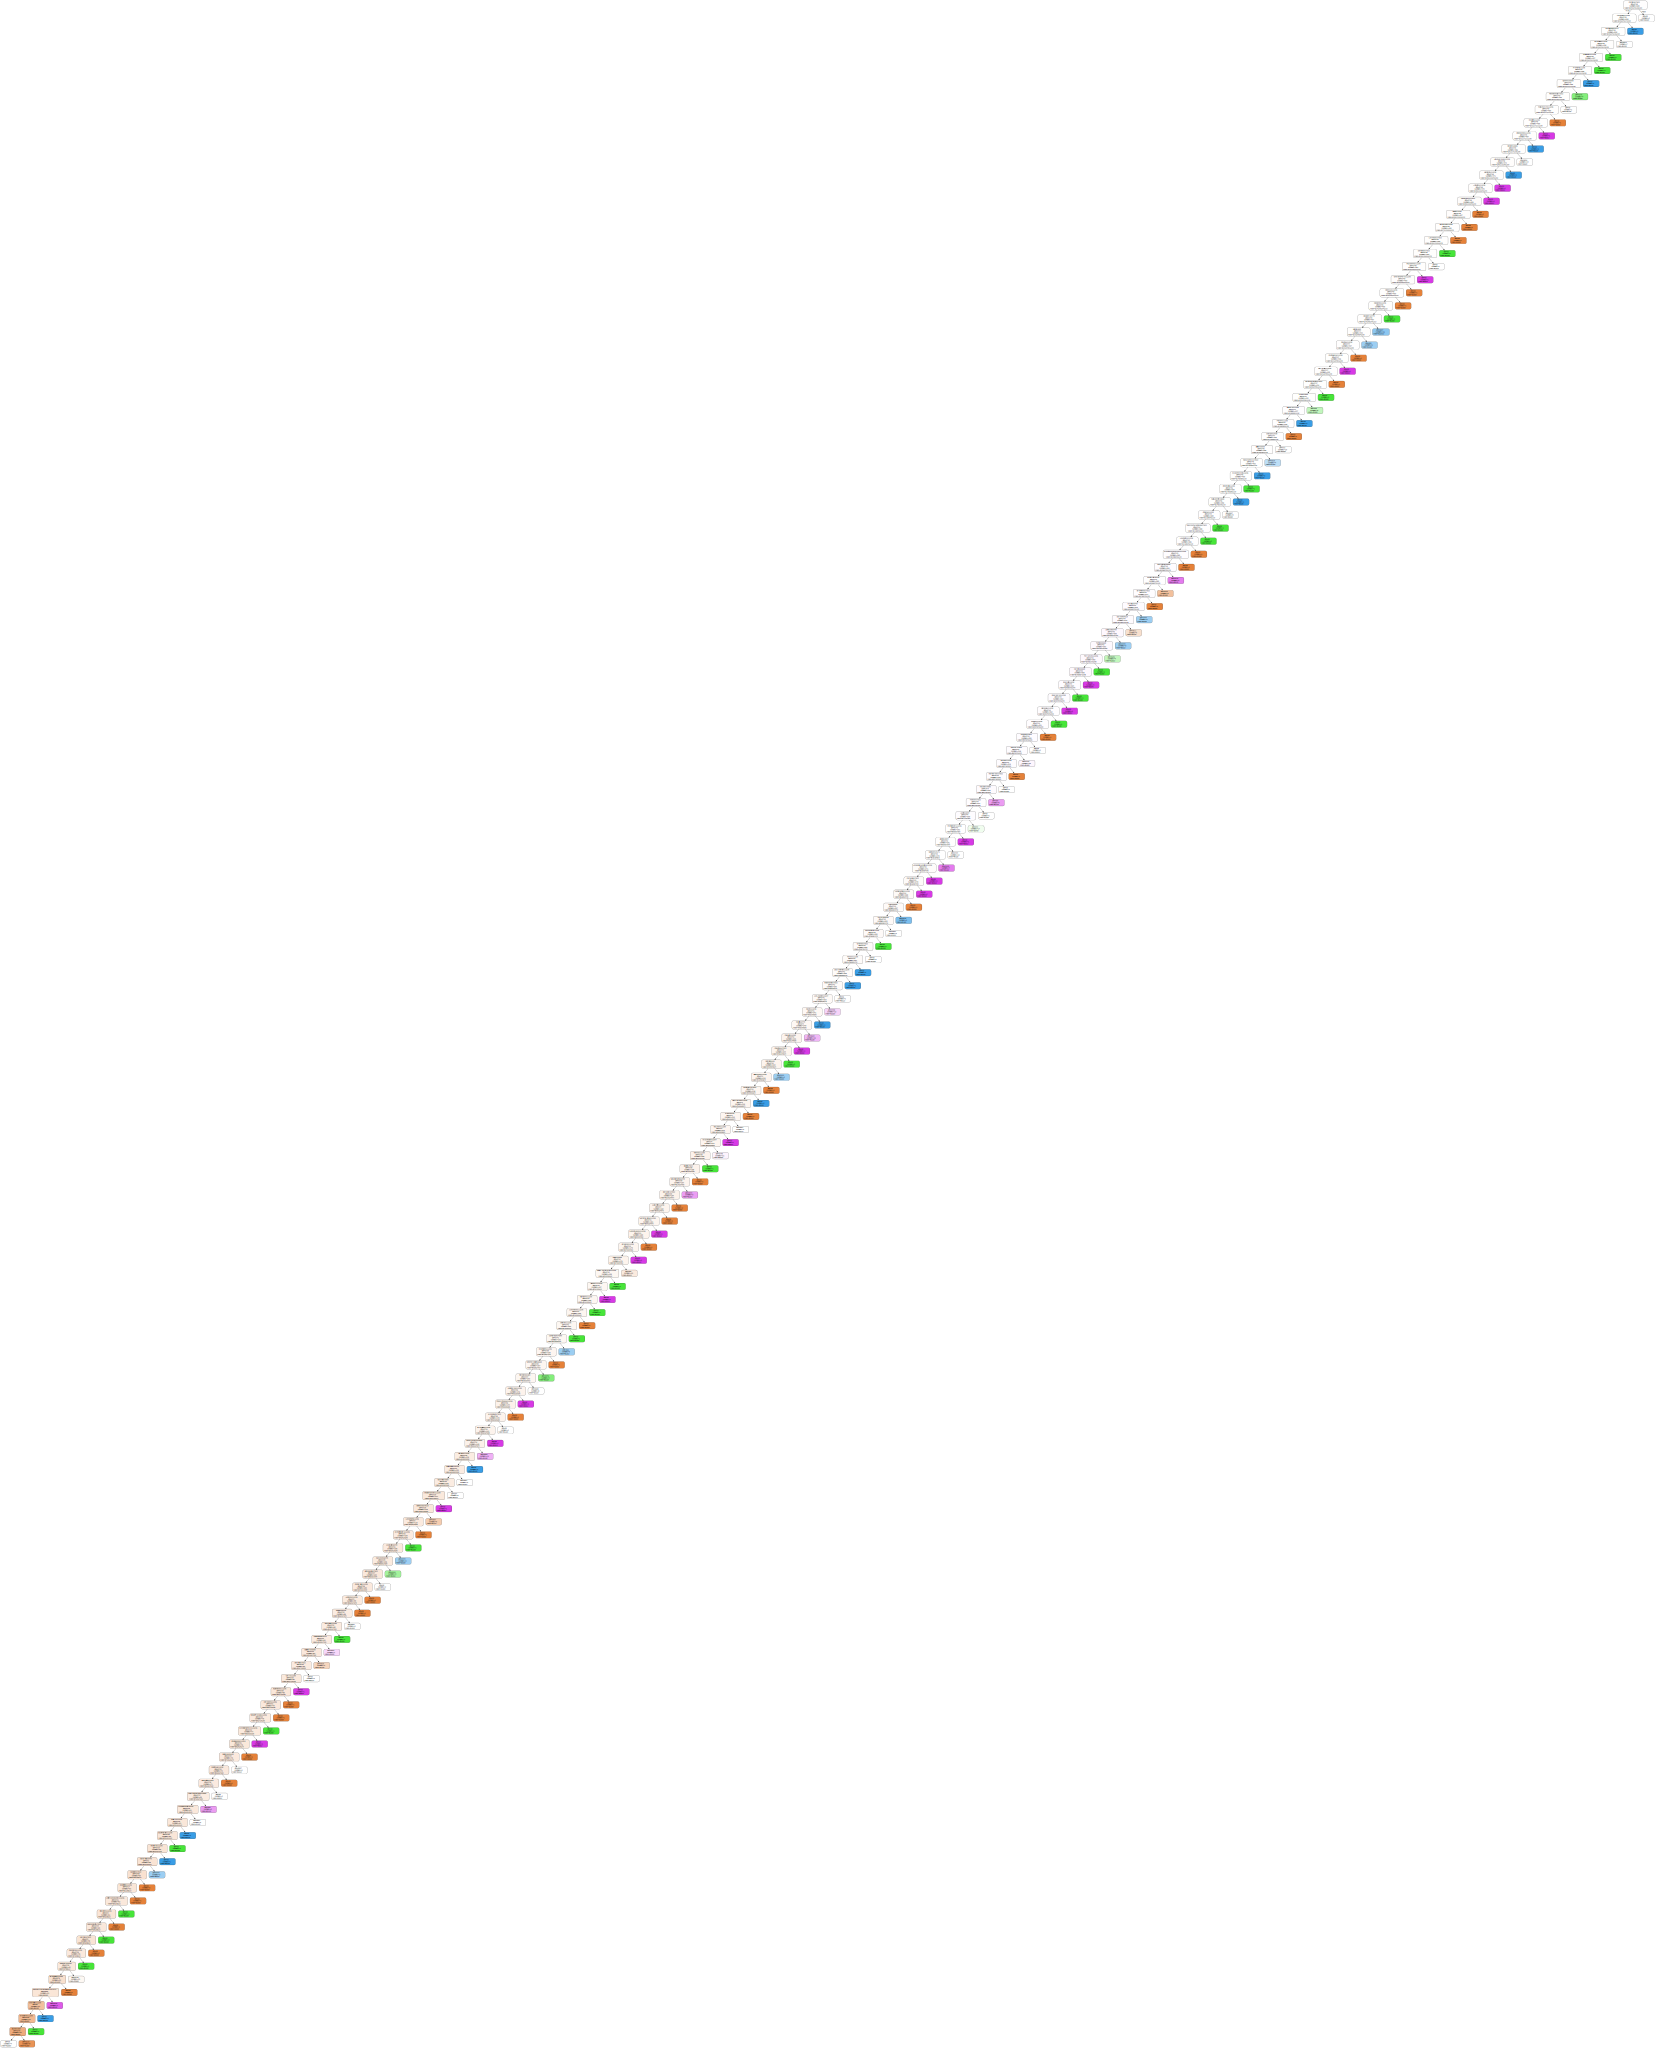

In [637]:
dot_data = export_graphviz(dtc_gs.best_estimator_,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X.columns,
                )

graph = graphviz.Source(dot_data) 

graph 

# after visually plotting the decision tree we can see 'Portland' has been set as our root node, 
# meaning Portland was the location that provided the most information gain.

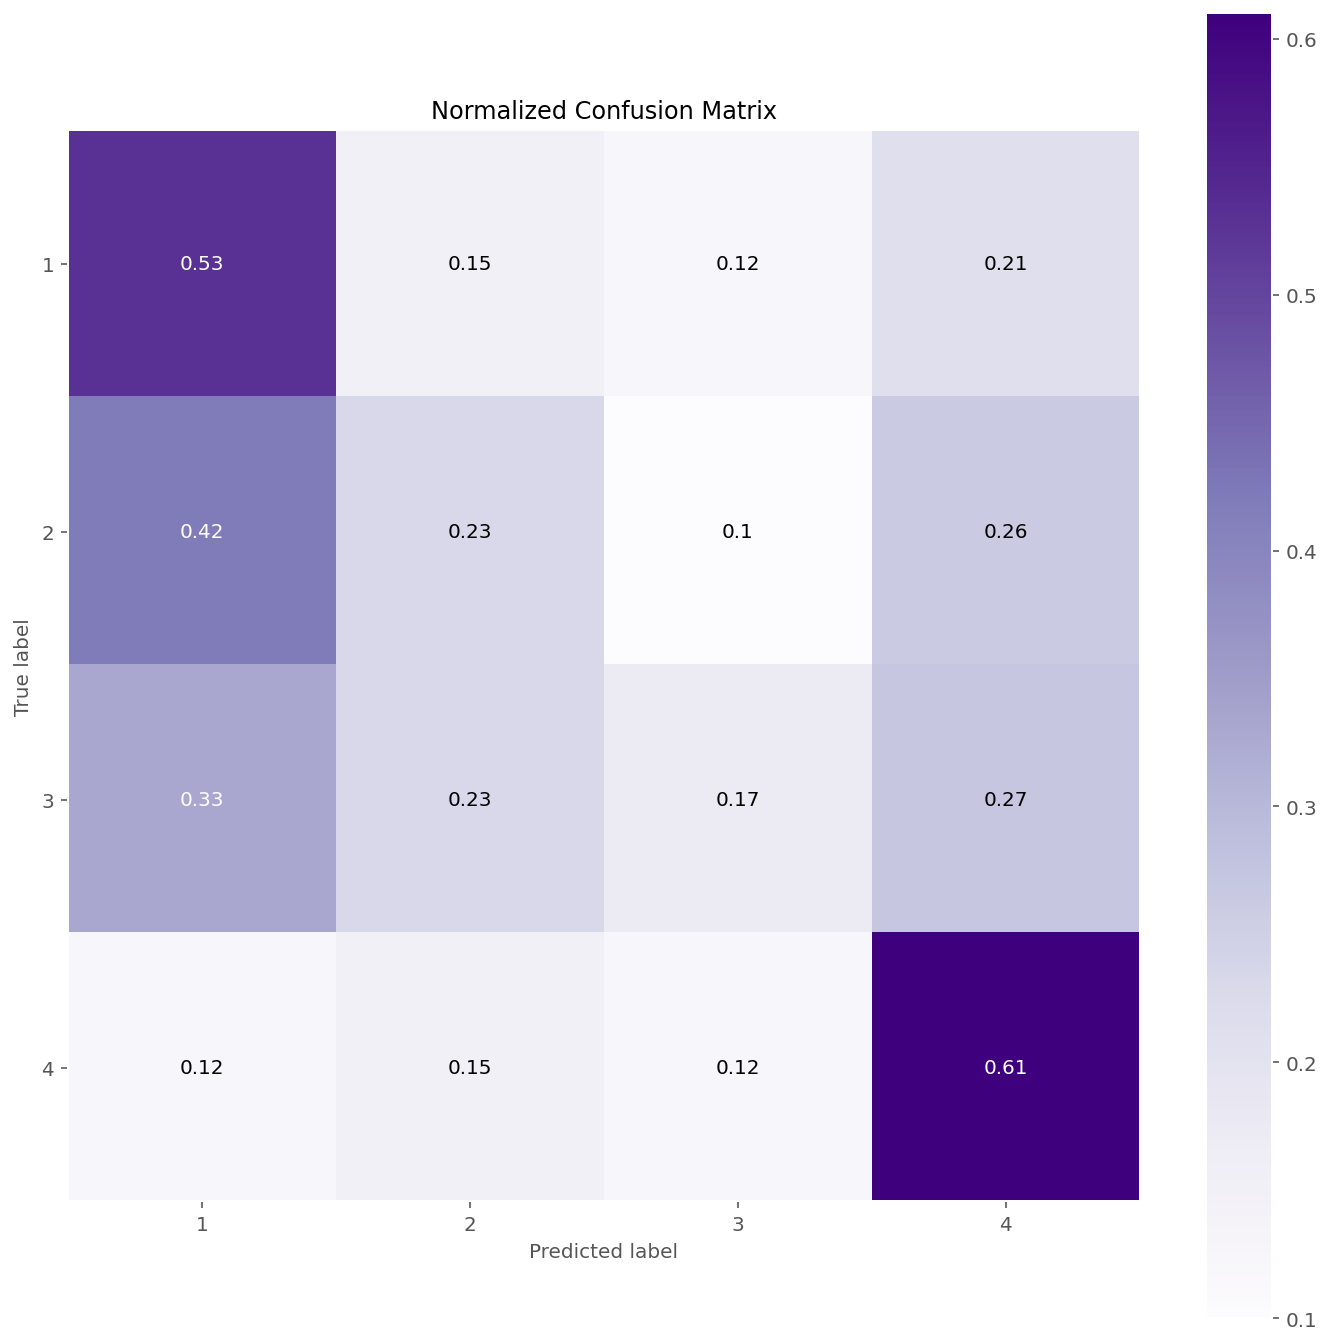

In [672]:
# let's plot the values being predicted we can see class 1 and class 4 were the better predicted
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12, 12), normalize=True, cmap='Purples')
plt.show()

In [694]:
# Now let's try a Logistic Regression Model
lr = LogisticRegression(max_iter=500, solver='liblinear')

In [695]:
params = {'C': np.logspace(-4, 4, 20),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False]}

gs = GridSearchCV(estimator=lr,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=500, solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [696]:
print(gs.best_params_)
print('best training score:', gs.best_score_)
gs_y_pred = gs.best_estimator_.predict(X_test)
score = accuracy_score(y_test, gs_y_pred)
print('best test score:', score)

{'C': 11.288378916846883, 'fit_intercept': True, 'penalty': 'l1'}
best training score: 0.34238012036497767
best test score: 0.375


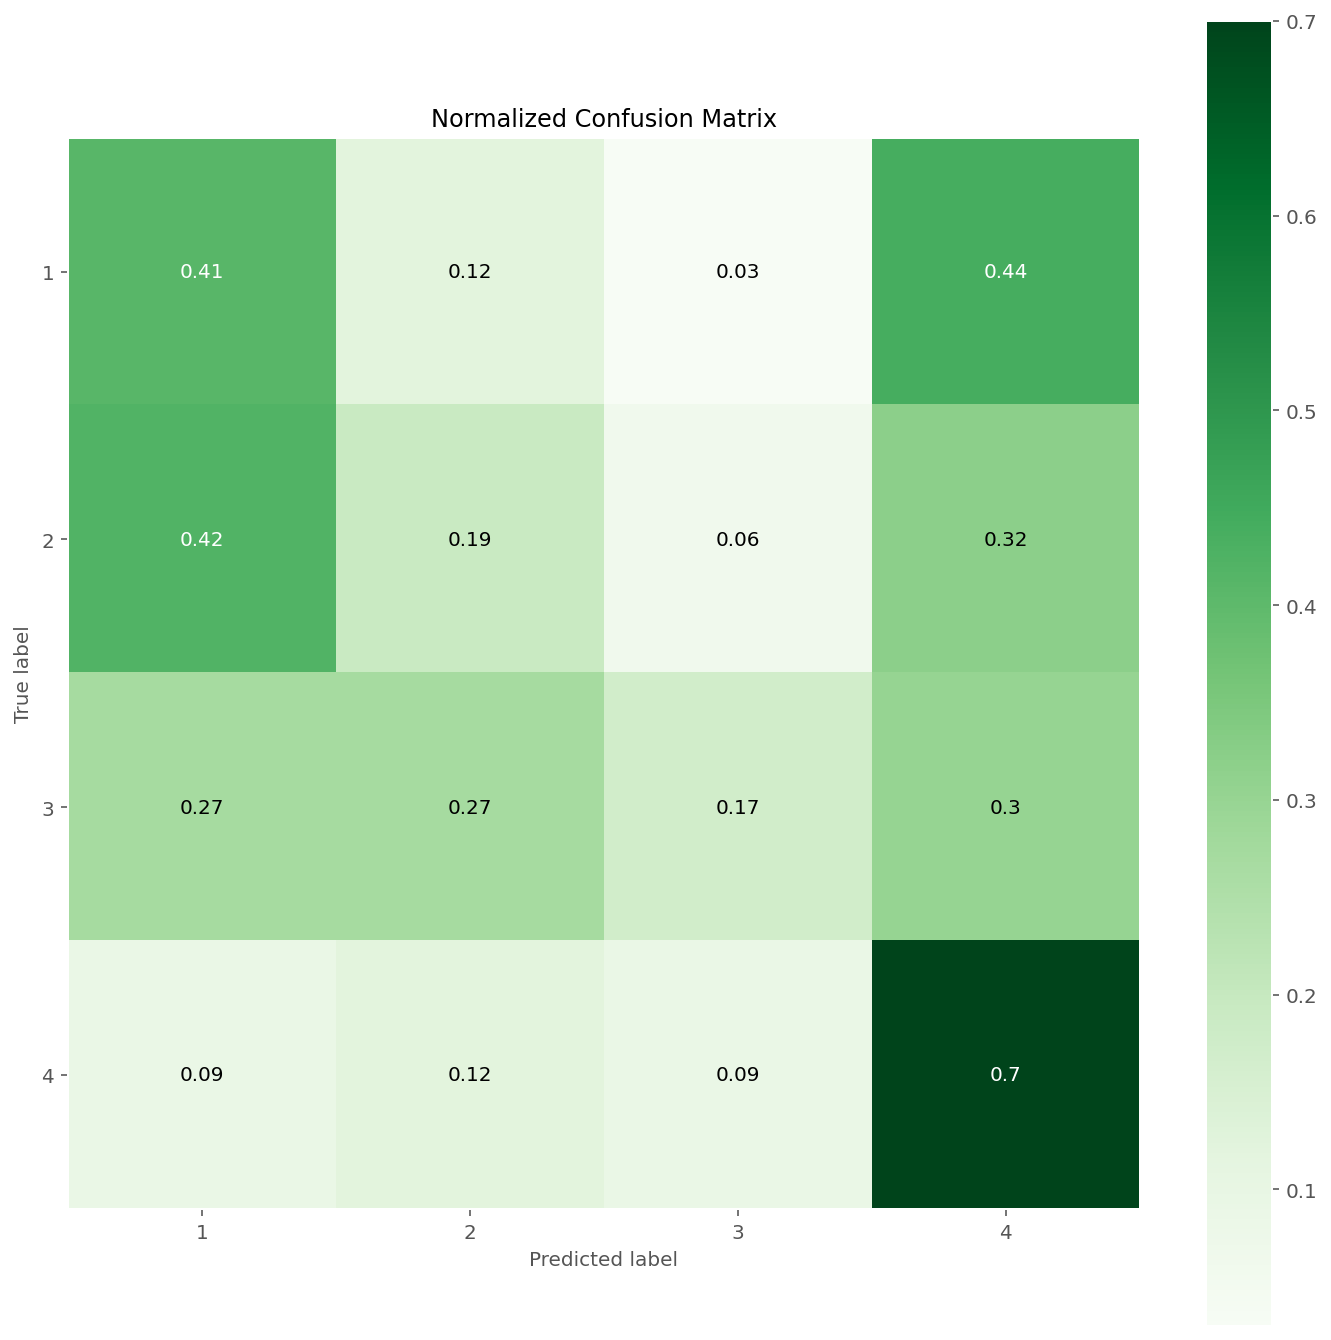

In [697]:
# let's plot the values being predicted we can see again class 1 and class 4 were the better predicted
# however there were better scores in the decision tree matrix
skplt.metrics.plot_confusion_matrix(y_test, gs_y_pred, figsize=(12, 12), normalize=True, cmap='Greens')
plt.show()

In [ ]:
# Display the coefficients/feature importances and write a short summary of what they mean.

In [698]:
# Decision Tree Features
dt_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance' : dtc_best.feature_importances_,
})

dt_features.sort_values('Importance', ascending=False, inplace=True)
dt_features.head(10)

Feature  Importance
126  Research Triangle Park    0.041026
16                  Boulder    0.030396
22                 Carolina    0.018833
134           San Francisco    0.014410
84                  Madison    0.013940
154                   Tulsa    0.013451
98           New York State    0.012775
136             Santa Clara    0.012558
123             Rancho Park    0.012116
106           Oklahoma City    0.011808

In [ ]:
# Using .feature_importances_ which will rank the features according to their importance. The ranking is 
# based on an importance measure ranging from 0 to 1, with 1 being the most important. The importance scores 
# of all features add up to 1. The score takes into account how many times the feature was used to make a 
# decision, how many data points were involved in each decision and how much the decision increased the 
# purity of the node. A feature with higher feature importance reduced the criterion (impurity) more than 
# the other features.

# In the data frame above we can see that the top 3 locations to predict the classification of salaries were:
# 1 - Research Triangle Park
# 2 - Boulder
# 3 - Carolina

In [701]:
# Logisitic Regression Coefficients
lr_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance Class 1 - minimum to 25% percentile' : gs.best_estimator_.coef_[0],
    'Importance Class 2 - 25% percentile to median' : gs.best_estimator_.coef_[1],
    'Importance Class 3 - median to 75% percentile' : gs.best_estimator_.coef_[2],
    'Importance Class 4 - 75% percentile to maximum': gs.best_estimator_.coef_[3]
})

lr_features.sort_values('Importance Class 4 - 75% percentile to maximum', ascending=False, inplace=True)
lr_features.head(10)

Feature  Importance Class 1 - minimum to 25% percentile  \
41                   Denver                                        0.147769   
22                 Carolina                                       -0.401626   
139                 Seattle                                        0.099680   
134           San Francisco                                        0.112004   
158              Washington                                        0.087172   
29                  Chicago                                       -0.099464   
97                 New York                                        0.161140   
126  Research Triangle Park                                       -0.559679   
10                   Austin                                       -0.071860   
82              Los Angeles                                        0.000000   

     Importance Class 2 - 25% percentile to median  \
41                                       -0.046962   
22                                       -0.400029   
139                                      -0.040449   
134                                      -0.151283   
158                                       0.090759   
29                                        0.111846   
97                                        0.070295   
126                                      -0.557563   
10                                        0.182232   
82                                        0.078830   

     Importance Class 3 - median to 75% percentile  \
41                                        0.387802   
22                                       -0.310182   
139                                       0.000000   
134                                       0.010021   
158                                       0.293116   
29                                        0.353444   
97                                        0.331518   
126                                       0.097551   
10                                        0.261919   
82                                        0.155361   

     Importance Class 4 - 75% percentile to maximum  
41                                         1.103469  
22                                         1.050473  
139                                        0.962762  
134                                        0.956261  
158                                        0.923223  
29                                         0.907110  
97                                         0.888307  
126                                        0.855469  
10                                         0.841327  
82                                         0.792273

In [ ]:
# As we have 4 different classes we have 4 different columns for our coefficients, sorting by class 4
# we can see Denver, Carolina and Seattle are the best locations for predicting the highest salaries.

In [702]:
lr_features.sort_values('Importance Class 1 - minimum to 25% percentile', ascending=False, inplace=True)
lr_features.head(3)

Feature  Importance Class 1 - minimum to 25% percentile  \
17   Brentwood                                        0.473080   
107   Olivette                                        0.473078   
59     Hampton                                        0.473078   

     Importance Class 2 - 25% percentile to median  \
17                                       -0.263068   
107                                      -0.263070   
59                                       -0.263065   

     Importance Class 3 - median to 75% percentile  \
17                                       -0.199410   
107                                      -0.199413   
59                                       -0.199413   

     Importance Class 4 - 75% percentile to maximum  
17                                        -0.016655  
107                                       -0.016673  
59                                        -0.016658

In [ ]:
# Looking at class 1 (lowest salaries) we can see that Brentwood, Olivette and Hampton are the strongest
# coefficients for predicting the lowest salaries.
# So we would look for jobs in Denver and avoid jobs searches in Brentwood for better earnings.

Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
Incorporate other text features from the title or summary that you believe will predict the salary.

In [703]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [704]:
from sklearn.feature_extraction.text import CountVectorizer

In [705]:
# I'm going to use NLP CountVectorizer to look at the most frequent words in the Job Title category
cvec = CountVectorizer(stop_words='english')
cvec.fit(df['Job Title'])

cvec_mat = cvec.transform(df['Job Title'])

#Words present
words = cvec.get_feature_names()

In [706]:
# number of different words
print(len(words))

392


In [707]:
# the top 10 most represented words in the Job Title category are
a = cvec_mat.sum(axis=0)
df_words = pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False)
df_words.head(10)

0
data       467
scientist  275
senior     163
engineer   122
analyst    118
learning   110
machine     98
science     52
sr          45
ai          37

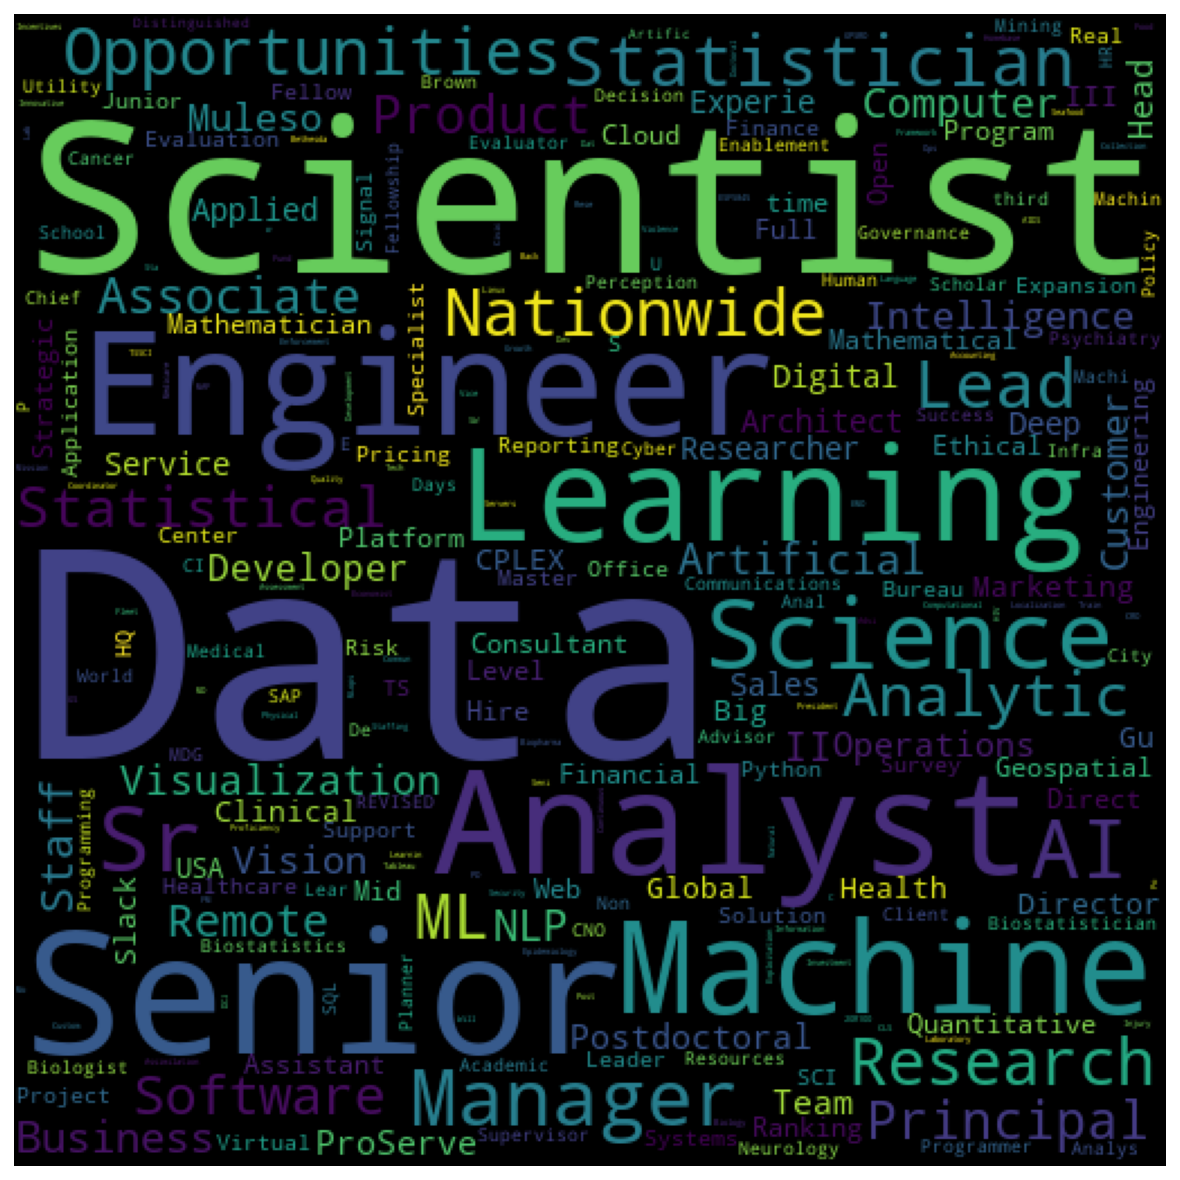

In [708]:
# let's visualise the list
Job_Title_wc = WordCloud(width=512, height=512, relative_scaling=0.5, max_words=250, collocations=False).generate(str(df['Job Title']))
plt.figure(figsize = (10,8))
plt.imshow(Job_Title_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [709]:
# let's save these word frequencies in a df to add to our features
Vect_title = pd.DataFrame(cvec.transform(df['Job Title']).toarray(), index = df['Job Title'].index, columns = words_desc)
Vect_title.head()

00  000  014  0414  0499u  100  13  1530  15933  1619  ...  utility  vice  \
1    0    0    0     0      0    0   0     0      0     0  ...        0     0   
2    0    0    0     0      0    0   0     0      0     0  ...        0     0   
4    0    0    0     0      0    0   0     0      0     0  ...        0     0   
6    0    0    0     0      0    0   0     0      0     0  ...        1     0   
26   0    0    0     0      0    0   0     0      0     0  ...        0     0   

    violence  virtual  vision  visualization  watson  web  weill  world  
1          0        0       0              0       0    0      0      0  
2          0        0       0              0       0    0      0      0  
4          0        0       0              0       0    0      0      0  
6          0        0       0              0       0    0      0      0  
26         0        0       0              0       0    0      0      0  

[5 rows x 392 columns]

In [710]:
# Now let's look at Job Description
cvec_desc = CountVectorizer(stop_words='english')
cvec_desc.fit(df['Job Description'])

cvec_desc_tra = cvec.transform(df['Job Description'])

#Words present
words_desc = cvec.get_feature_names()

In [711]:
# the top 10 most represented words in the Job Description category are
a_desc = cvec_desc_tra.sum(axis=0)
df_desc = pd.DataFrame(a_desc,columns=words_desc).transpose().sort_values(by=0,ascending=False)
df_desc.head(10)

0
data        1241
experience   295
analysis     117
learning     100
science       97
ml            79
machine       73
scientist     72
analytics     64
team          63

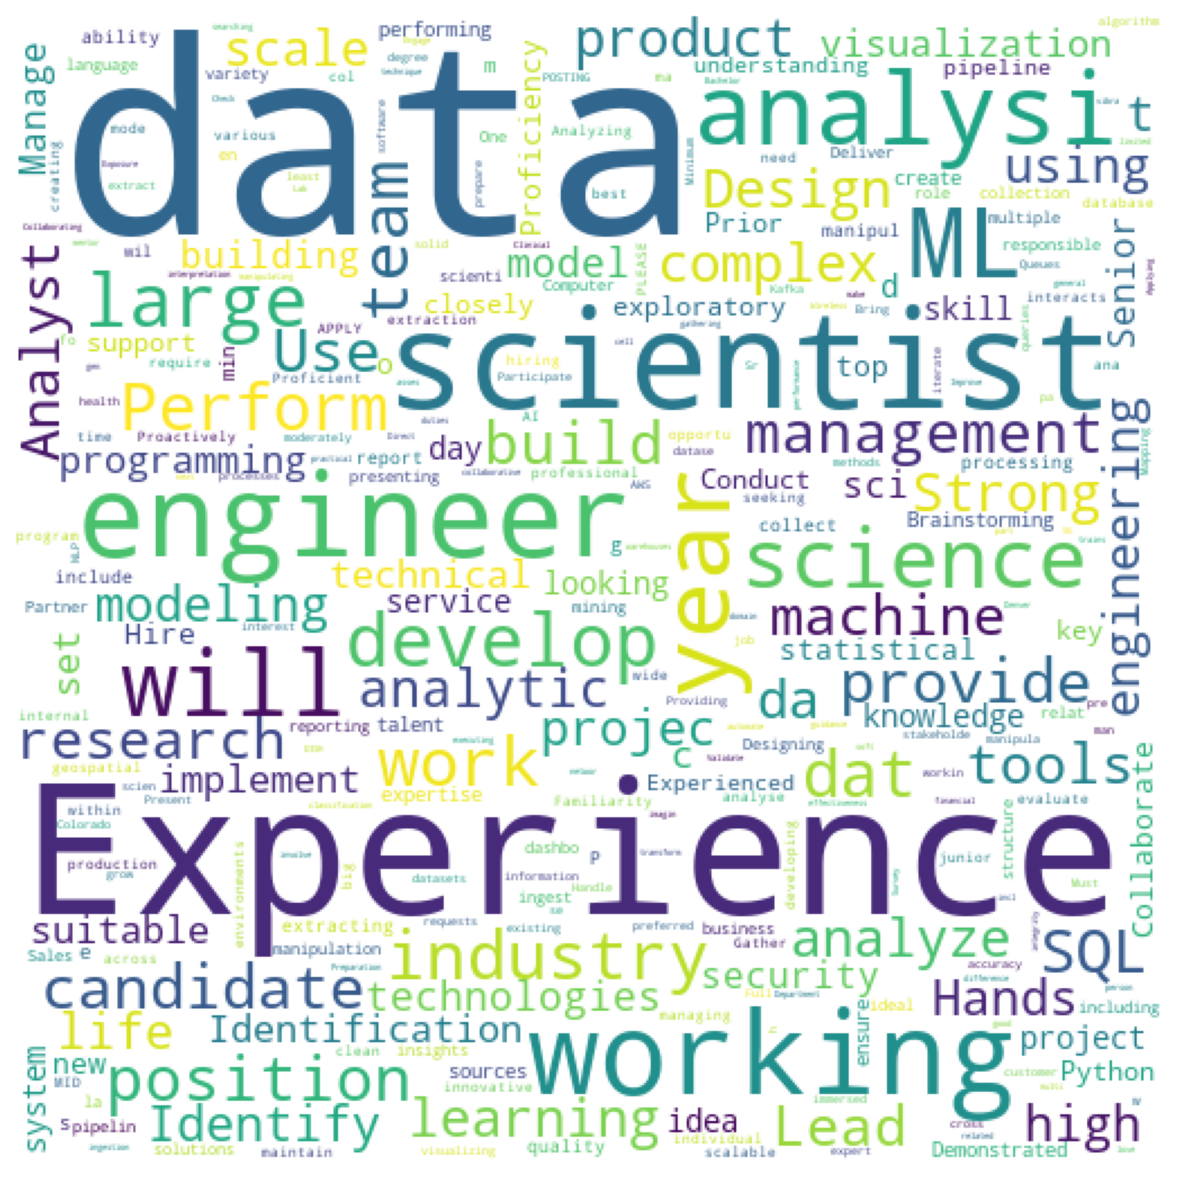

In [712]:
# let's see what important words appear in 'Job Description'
Job_Description_wc = WordCloud(width=512, height=512, relative_scaling=0.5, max_words=300, collocations=False, background_color="white").generate(str(df['Job Description']))
plt.figure(figsize = (10,8))
plt.imshow(Job_Description_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [713]:
# let's save these word frequencies in a df to add to our features
Vect_desc = pd.DataFrame(cvec.transform(df['Job Description']).toarray(), index = df['Job Description'].index, columns = words_desc)
Vect_desc.head()

00  000  014  0414  0499u  100  13  1530  15933  1619  ...  utility  vice  \
1    0    0    0     0      0    0   0     0      0     0  ...        0     0   
2    0    0    0     0      0    0   0     0      0     0  ...        0     0   
4    0    0    0     0      0    0   0     0      0     0  ...        0     0   
6    0    0    0     0      0    0   0     0      0     0  ...        0     0   
26   0    0    0     0      0    0   0     0      0     0  ...        0     0   

    violence  virtual  vision  visualization  watson  web  weill  world  
1          0        0       0              0       0    0      0      0  
2          0        0       0              0       0    0      0      0  
4          0        0       0              1       0    0      0      0  
6          0        0       0              0       0    0      0      0  
26         0        0       0              0       0    0      0      0  

[5 rows x 392 columns]

Then build new classification models including also those features. Do they add any value?

In [714]:
# By combining our dummified locations and vectorized 'Job Title' and 'Job Description' we have our new predictors
frames_words = (df_dum, Vect_desc, Vect_title)
df_dum_vec = pd.concat(frames_words, axis=1)
df_dum_vec

Addison  Albuquerque  Allegany  Alpharetta  Annapolis  \
1            0            0         0           0          0   
2            0            0         0           0          0   
4            0            0         0           0          0   
6            0            0         0           0          0   
26           0            0         0           0          0   
33           0            0         0           0          0   
41           0            0         0           0          0   
70           0            0         0           0          0   
77           0            0         0           0          0   
80           0            0         0           0          0   
81           0            0         0           0          0   
83           0            0         0           0          0   
86           0            0         0           0          0   
88           0            0         0           0          0   
93           0            0         0           0          0   
94           0            0         0           0          0   
95           0            0         0           0          0   
99           0            0         0           0          0   
100          0            0         0           0          0   
101          0            0         0           0          0   
102          0            0         0           0          0   
104          0            0         0           0          0   
111          0            0         0           0          0   
112          0            0         0           0          0   
116          0            0         0           0          0   
117          0            0         0           0          0   
129          0            0         0           0          0   
134          0            0         0           0          0   
140          0            0         0           0          0   
146          0            0         0           0          0   
148          0            0         0           0          0   
162          0            0         0           0          0   
165          0            0         0           0          0   
169          0            0         0           0          0   
175          0            0         0           0          0   
216          0            0         0           0          0   
217          0            0         0           0          0   
365          0            0         0           0          0   
374          0            0         0           0          0   
1500         0            0         0           0          0   
1513         0            0         0           0          0   
1528         0            0         0           0          0   
1533         0            0         0           0          0   
1693         0            0         0           0          0   
1708         0            0         0           0          0   
2377         0            0         0           0          0   
2980         0            0         0           0          0   
2981         0            0         0           0          0   
2983         0            0         0           0          0   
2985         0            0         0           0          0   
2986         0            0         0           0          0   
2992         0            0         0           0          0   
2993         0            0         0           0          0   
3001         0            0         0           0          0   
3002         0            0         0           0          0   
3007         0            0         0           0          0   
3008         0            0         0           0          0   
3012         0            0         0           0          0   
3034         0            0         0           0          0   
3035         0            0         0           0          0   
3038         0            0         0           0          0   
3046         0            0         0  

In [723]:
# getting our target and predictive variable
X_vec = df_dum_vec
y = df['Salary_Class']

In [724]:
# let's do a train test split and stratify y for consistancy
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y, stratify=y, test_size = 0.2, random_state = 42)

Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. Discuss model coefficients or feature importances as applicable.

In [718]:
# First let's try the Logistic Regression with our added predictors
lr_vect = LogisticRegressionCV(solver='liblinear', 
                               max_iter=10000)

In [719]:
lr_params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 20)],
          'fit_intercept': [True, False],}

lr_gs_vect = GridSearchCV(estimator=lr_vect,
                  param_grid=lr_params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=2,
                  verbose=1)

lr_gs_vect.fit(X_train_vec, y_train_vec)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(max_iter=10000, solver='liblinear'),
             n_jobs=2,
             param_grid={'Cs': [array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [720]:
print(lr_gs_vect.best_params_, '\n')
print('best training score', lr_gs_vect.best_score_)
lr_vect_pred = lr_gs_vect.best_estimator_.predict(X_test_vec)
score = accuracy_score(y_test_vec, lr_vect_pred)
print('best test score', score)

{'Cs': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'fit_intercept': True, 'penalty': 'l1'} 

best training score 0.513744903902155
best test score 0.6015625


In [ ]:
# LogisticRegression score from just location as predictors = 0.375
# adding the NLP features has incresed our test score to 0.602

In [721]:
# Logisitic Regression Coefficients
lr_vect_features = pd.DataFrame({
    'Feature': X_vec.columns,
    'Importance Class 1' : lr_gs_vect.best_estimator_.coef_[0],
    'Importance Class 2' : lr_gs_vect.best_estimator_.coef_[1],
    'Importance Class 3' : lr_gs_vect.best_estimator_.coef_[2],
    'Importance Class 4':  lr_gs_vect.best_estimator_.coef_[3]
})

lr_vect_features.sort_values('Importance Class 4', ascending=False, inplace=True)
lr_vect_features.head(10)

Feature  Importance Class 1  Importance Class 2  \
38         Dearborn            0.000000                 0.0   
597       architect           -0.492542                 0.0   
61        Hawthorne            0.000000                 0.0   
698         ethical            0.000000                 0.0   
23             Cary            0.000000                 0.0   
362  infrastructure            0.000000                 0.0   
12         Bellevue            0.000000                 0.0   
34       Costa Mesa            0.000000                 0.0   
53       Fort Lewis            0.000000                 0.0   
802         mission            0.000000                 0.0   

     Importance Class 3  Importance Class 4  
38                  0.0           40.878773  
597                 0.0           28.609587  
61                  0.0           18.240794  
698                 0.0           17.988228  
23                  0.0           17.982440  
362                 0.0           17.247008  
12                  0.0           16.246552  
34                  0.0           15.412203  
53                  0.0           14.658048  
802                 0.0           14.643852

In [ ]:
# In our new LogisticRegression model with added NLP features we can see the most important words to have
# within the job vacancy (to predict the highest salaries) are: 'Dearborn', 'architect' and Hawthorne.
# Whilst we have the df sorted by class 4 it is also interesting to see that the model has removed the majority
# of the predictor words (scoring highly for class 4) when using the to predict classes 1, 2 and 3.

In [722]:
lr_vect_features.sort_values('Importance Class 1', ascending=False, inplace=True)
lr_vect_features.head(3)

Feature  Importance Class 1  Importance Class 2  \
604        associate            7.948778           -0.433049   
17         Brentwood            6.177157            0.000000   
619  biostatistician            5.809609            0.000000   

     Importance Class 3  Importance Class 4  
604           -0.361727          -10.652435  
17             0.000000            0.000000  
619            0.000000           -5.078233

In [ ]:
# We can now see the most important words to predict a lower salary (class 1) are 'associate', 'Brentwood'
# and 'biostatistician'. So if we wanted a higher salary position we would avoid associate jobs in Brentwood.

In [725]:
# Let's do the same with the Decision Tree Classifier model
dtc_vect = DecisionTreeClassifier()

In [726]:
# gridsearch Decision Tree
dtc_vect_params = {
    'max_depth': list(range(1, 12))+[None],
    'max_features': [None, 2, 3, 4, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 10, 12, 13, 15, 20, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}

# set the gridsearch

dtc_gs_vect = GridSearchCV(dtc_vect, 
                           dtc_vect_params, 
                           cv=5,
                           verbose=1, 
                           n_jobs=-2, 
                           return_train_score=True)

dtc_gs_vect.fit(X_train_vec, y_train_vec)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None],
                         'max_features': [None, 2, 3, 4, 5, 10, 15, 20],
                         'min_samples_split': [2, 3, 4, 5, 10, 12, 13, 15, 20,
                                               30, 40, 50]},
             return_train_score=True, verbose=1)

In [727]:
print(dtc_gs_vect.best_params_, '\n')
print('best training score', dtc_gs_vect.best_score_)
dtc_vect_pred = dtc_gs_vect.best_estimator_.predict(X_test_vec)
score = accuracy_score(y_test_vec, dtc_vect_pred)
print('best test score', score)

{'ccp_alpha': 0, 'max_depth': None, 'max_features': 2, 'min_samples_split': 2} 

best training score 0.5296059017666473
best test score 0.5390625


In [ ]:
# DecisionTree score from just location as predictors = 0.390625
# So adding the NLP features has increased our best test score to 0.539

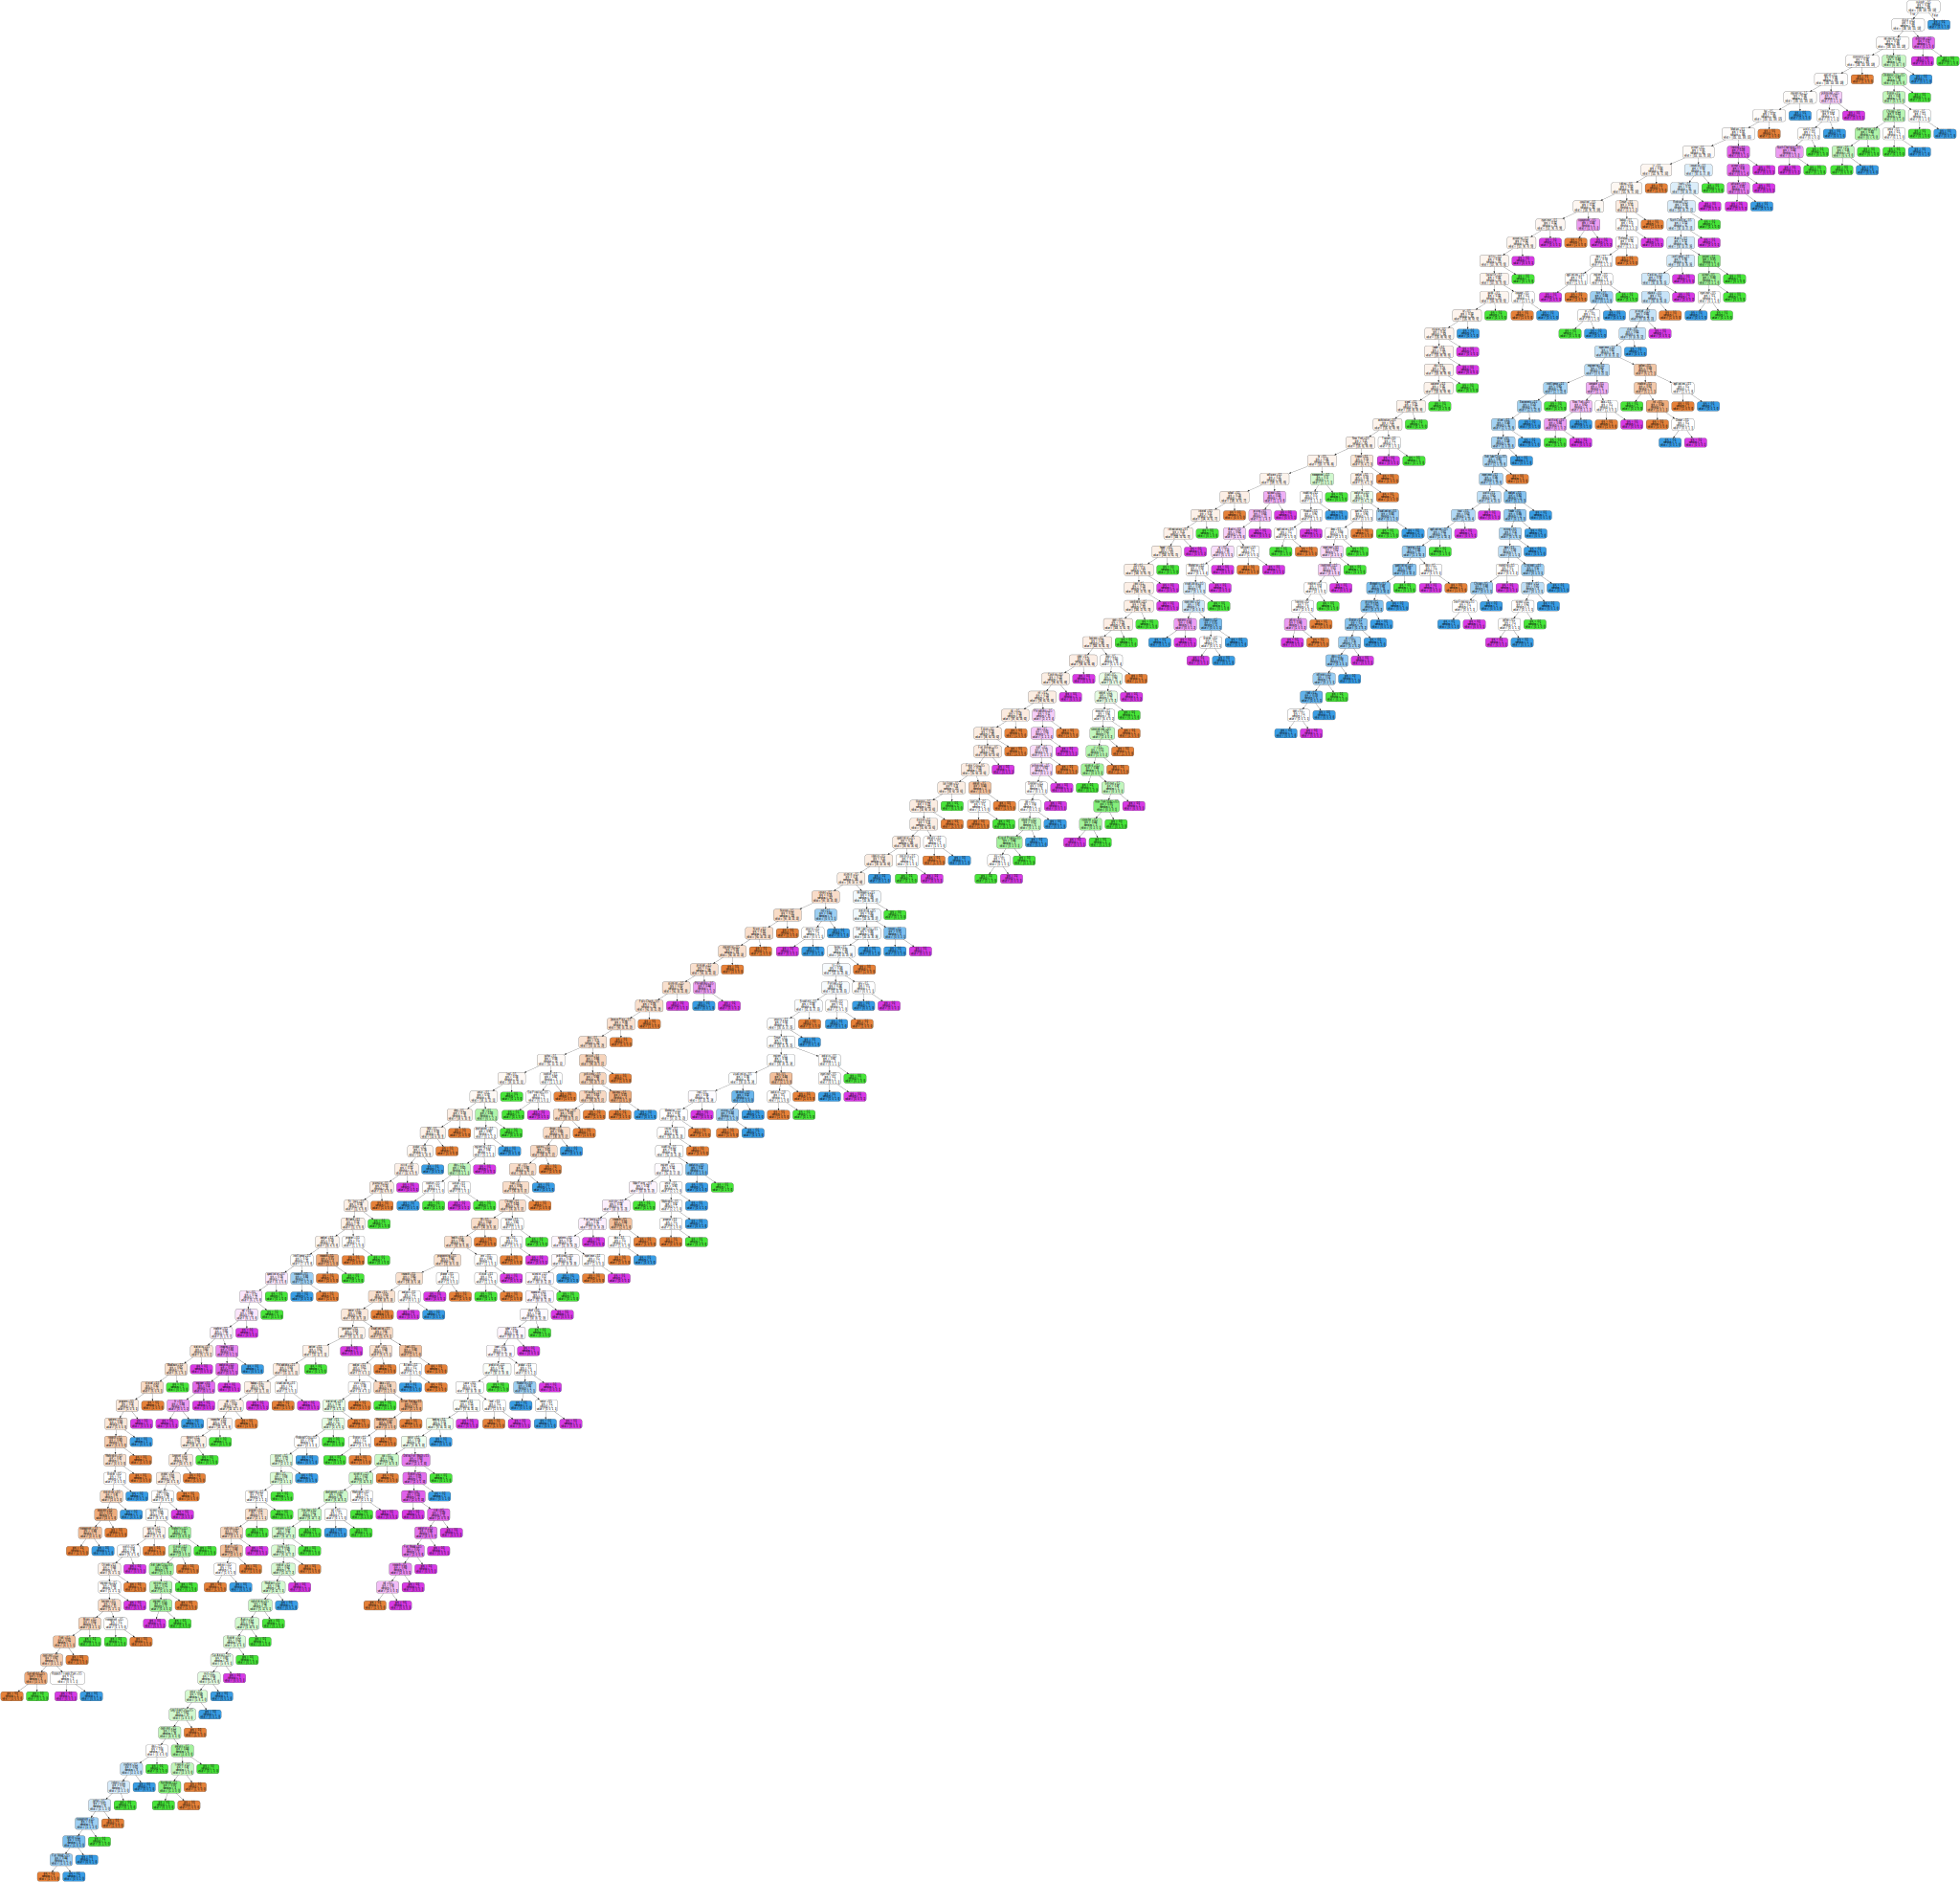

In [728]:
dot_data = export_graphviz(dtc_gs_vect.best_estimator_,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X_vec.columns,
                )

graph = graphviz.Source(dot_data) 

graph 
# when we visualize the decision tree we can now see that 'mulesoft' is the root node (a software company)

In [729]:
# Decision Tree Features
dtc_vect_features = pd.DataFrame({
    'Feature': X_vec.columns,
    'Importance' : dtc_gs_vect.best_estimator_.feature_importances_,
})

dtc_vect_features.sort_values('Importance', ascending=False, inplace=True)
dtc_vect_features.head(10)

Feature  Importance
893         senior    0.046837
310     experience    0.030367
300    engineering    0.020547
510       software    0.016982
553  visualization    0.016451
271           data    0.015531
807       mulesoft    0.014656
393     management    0.014623
888      scientist    0.014465
515            sql    0.013948

In [ ]:
# We can now see that 'senior', 'experience' and 'engineering' has the highest feature importance in predicting
# the salary classifications with the added NLP features as predictors.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [738]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Our LogisticRegression model gave us the best test score so we'll use that to tune 

In [739]:
lr_params = {'penalty': ['l1', 'l2'],
          'Cs': [np.logspace(-4, 4, 20)],
          'fit_intercept': [True, False],}

lr_gs_vect = GridSearchCV(estimator=lr_vect,
                  param_grid=lr_params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=2,
                  verbose=1)

lr_gs_vect.fit(X_train_vec, y_train_vec)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=LogisticRegressionCV(max_iter=10000, solver='liblinear'),
             n_jobs=2,
             param_grid={'Cs': [array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [740]:
# Here are our LR scores after using GridSearch 
print(lr_gs_vect.best_params_, '\n')
print('best training score', lr_gs_vect.best_score_)
lr_vect_pred = lr_gs_vect.best_estimator_.predict(X_test_vec)
score = accuracy_score(y_test_vec, lr_vect_pred)
print('best test score', score)

{'Cs': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'fit_intercept': True, 'penalty': 'l1'} 

best training score 0.5176470588235295
best test score 0.609375


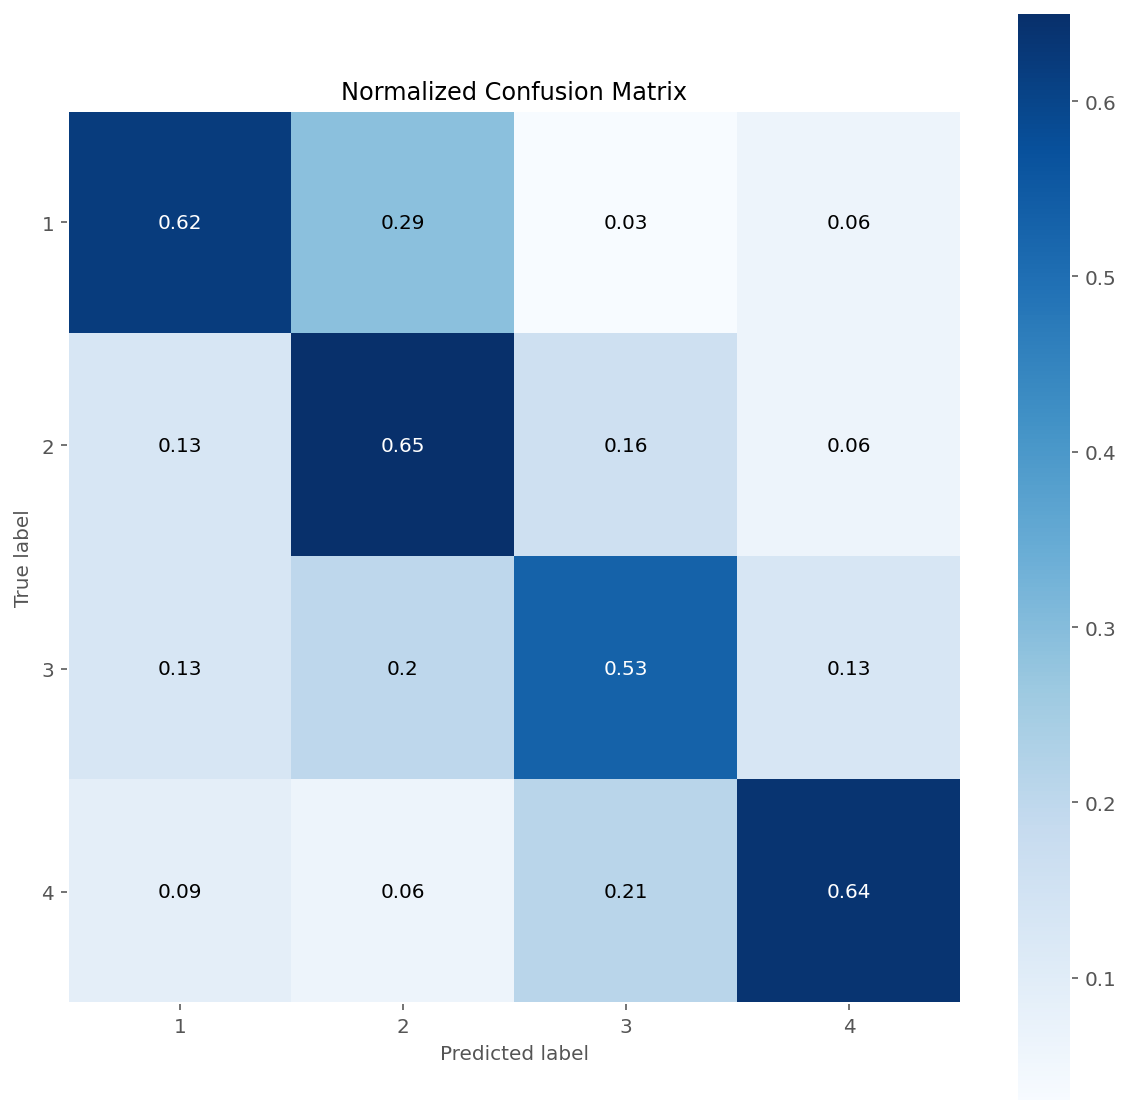

In [741]:
# checking the predictions against y values we can see that there are much higher values for true predictions
# with smaller % of false negative and false postive values 
skplt.metrics.plot_confusion_matrix(y_test_vec, lr_gs_vect.best_estimator_.predict(X_test_vec), normalize=True, figsize=(10,10))
plt.show()

In [742]:
# It appears that this model performed just okay for the most classes, with precision, recall metrics all
# above 0.5 (baseline accuracy = 0.26).
# The new model though performs much better for the “more important” classification class 4 - the highest salaries.
# Class 4 has the highest precision and f1-score.
print(classification_report(y_test_vec, lr_gs_vect.best_estimator_.predict(X_test_vec)))

              precision    recall  f1-score   support

           1       0.66      0.62      0.64        34
           2       0.53      0.65      0.58        31
           3       0.55      0.53      0.54        30
           4       0.72      0.64      0.68        33

    accuracy                           0.61       128
   macro avg       0.61      0.61      0.61       128
weighted avg       0.62      0.61      0.61       128



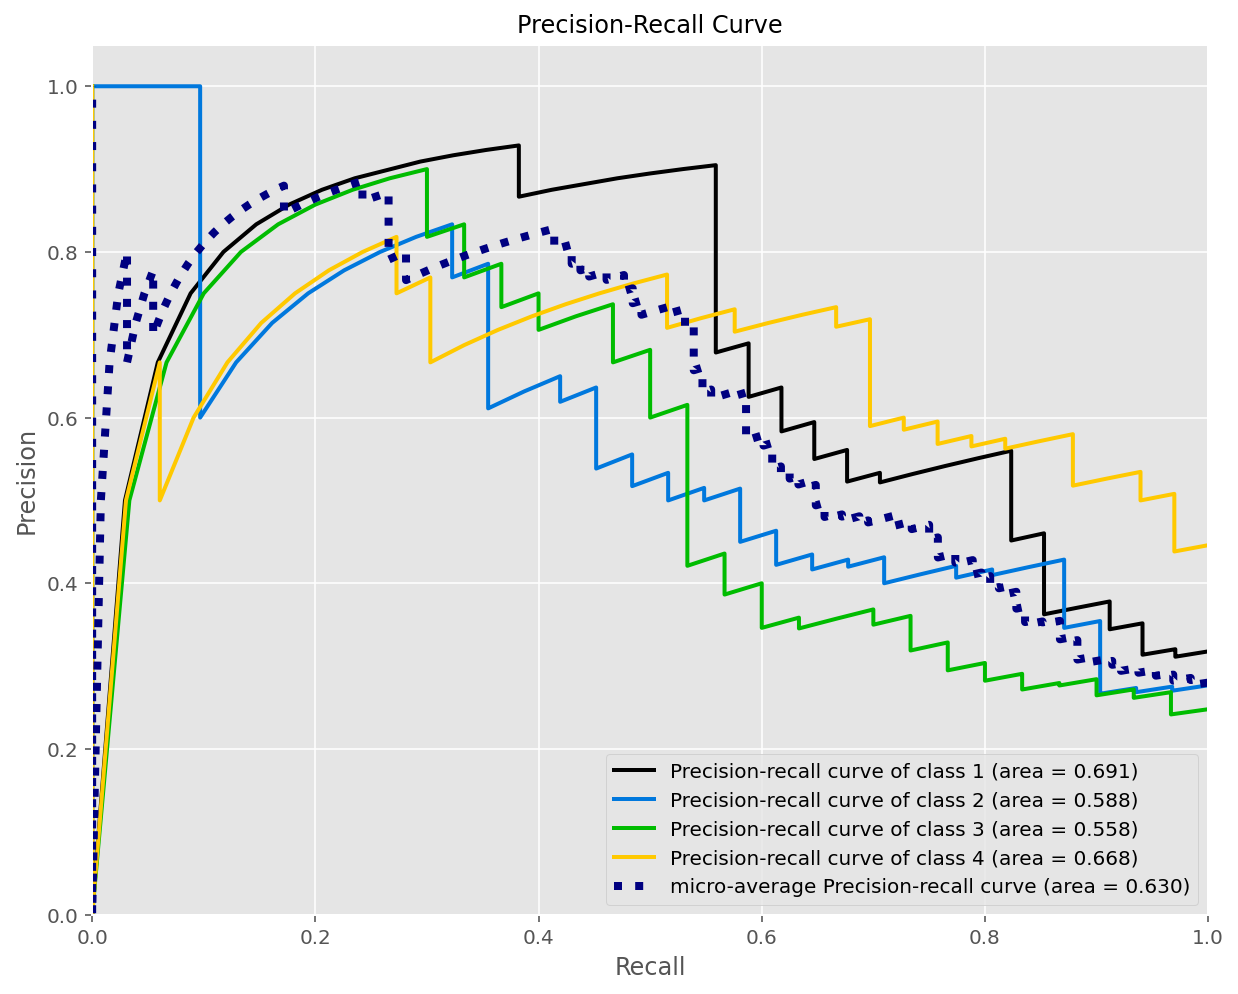

In [743]:
# The precision recall curves for class 1 and class 4 are higher than class 2 and 3, meaning there are
# less false positive and negative predictions in these classes, which is backed up by the confusion matrix above.
skplt.metrics.plot_precision_recall(y_test_vec, lr_gs_vect.best_estimator_.predict_proba(X_test_vec), figsize=(10,8))
plt.show()

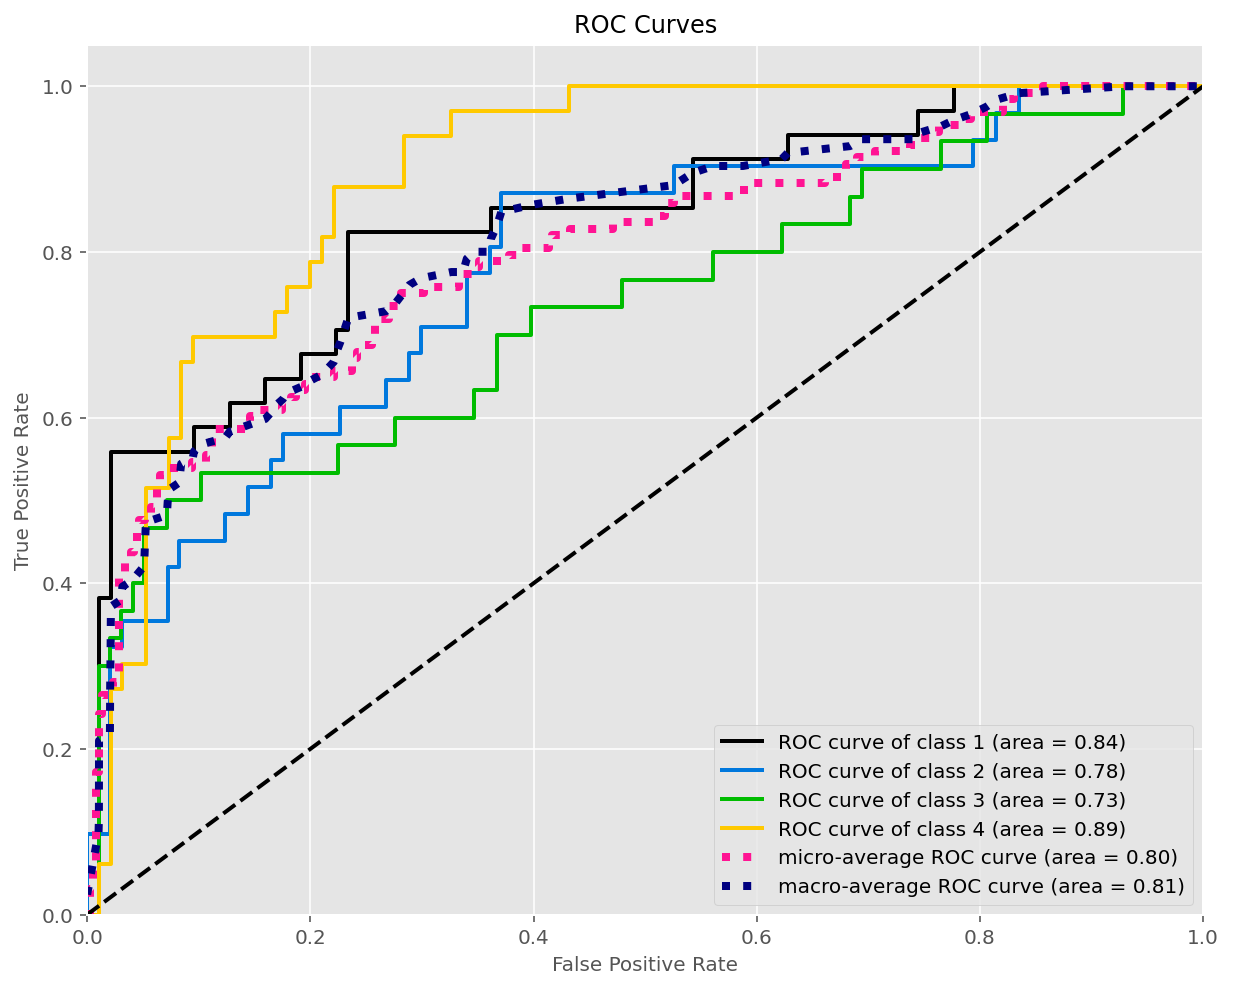

In [744]:
skplt.metrics.plot_roc(y_test_vec, lr_gs_vect.best_estimator_.predict_proba(X_test_vec), figsize=(10,8))
plt.show()

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client 
incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.

In [765]:
# We want to look at the thresholds of each class here and adjust for finding more 'low' salaries and less
# 'high' salaries.
# Let's have a look at the predictions from the model above
Y_pp = pd.DataFrame(lr_gs_vect.best_estimator_.predict_proba(X_test_vec), 
                    columns=['minimum to 25% percentile salaries', '25% percentile to median salaries', 'median to 75% percentile salaries', '75% percentile to maximum salaries'])
Y_pp

minimum to 25% percentile salaries  25% percentile to median salaries  \
0                              0.692583                           0.160674   
1                              0.013094                           0.176011   
2                              0.052612                           0.100202   
3                              0.017474                           0.080271   
4                              0.001683                           0.083974   
5                              0.121671                           0.168918   
6                              0.004376                           0.187714   
7                              0.040253                           0.543931   
8                              0.470480                           0.249116   
9                              0.083209                           0.050031   
10                             0.013576                           0.196295   
11                             0.058296                           0.642675   
12                             0.000572                           0.545078   
13                             0.019046                           0.111013   
14                             0.749911                           0.093191   
15                             0.694816                           0.121871   
16                             0.466800                           0.373010   
17                             0.213536                           0.367758   
18                             0.083715                           0.420463   
19                             0.454140                           0.202342   
20                             0.000574                           0.034858   
21                             0.756465                           0.093676   
22                             0.705540                           0.231428   
23                             0.012575                           0.379692   
24                             0.013550                           0.147287   
25                             0.293583                           0.422657   
26                             0.386837                           0.439225   
27                             0.013432                           0.148215   
28                             0.092073                           0.129556   
29                             0.196589                           0.494461   
30                             0.602315                           0.173559   
31                             0.080253                           0.509274   
32                             0.001468                           0.456811   
33                             0.023483                           0.505778   
34                             0.002020                           0.100689   
35                             0.098792                           0.050604   
36                             0.017601                           0.676399   
37                             0.026168                           0.255911   
38                             0.002872                           0.297274   
39                             0.686954                           0.167219   
40                             0.002687                           0.121177   
41                             0.806390                           0.136614   
42                             0.663738                           0.201680   
43                             0.353941                           0.403450   
44                             0.000299                           0.078310   
45                             0.001604                           0.237011   
46                             0.129706                           0.701951   
47                             0.020231                           0.331068   
48                             0.063394                           0.644870   
49                             0.060136                           0.632743   
50                         

In [766]:
# We can use .describe() to look at the mean values for each column predictions
Y_pp.describe()

minimum to 25% percentile salaries  25% percentile to median salaries  \
count                          128.000000                         128.000000   
mean                             0.220033                           0.303241   
std                              0.269311                           0.202456   
min                              0.000003                           0.022142   
25%                              0.013544                           0.135915   
50%                              0.076042                           0.251318   
75%                              0.384939                           0.454100   
max                              0.812177                           0.776533   

       median to 75% percentile salaries  75% percentile to maximum salaries  
count                         128.000000                        1.280000e+02  
mean                            0.303924                        1.728020e-01  
std                             0.215311                        2.877223e-01  
min                             0.031796                        1.395960e-19  
25%                             0.145799                        6.984349e-10  
50%                             0.248411                        2.954715e-05  
75%                             0.378348                        2.931687e-01  
max                             0.936434                        7.958805e-01

In [768]:
# Let's change the threshold to 0.2 to lower the salaries over the median.

Y_pp['new threshold classification 4'] = [4 if x >= 0.70 else 0 for x in Y_pp['75% percentile to maximum salaries']]

Y_pp

minimum to 25% percentile salaries  25% percentile to median salaries  \
0                              0.692583                           0.160674   
1                              0.013094                           0.176011   
2                              0.052612                           0.100202   
3                              0.017474                           0.080271   
4                              0.001683                           0.083974   
5                              0.121671                           0.168918   
6                              0.004376                           0.187714   
7                              0.040253                           0.543931   
8                              0.470480                           0.249116   
9                              0.083209                           0.050031   
10                             0.013576                           0.196295   
11                             0.058296                           0.642675   
12                             0.000572                           0.545078   
13                             0.019046                           0.111013   
14                             0.749911                           0.093191   
15                             0.694816                           0.121871   
16                             0.466800                           0.373010   
17                             0.213536                           0.367758   
18                             0.083715                           0.420463   
19                             0.454140                           0.202342   
20                             0.000574                           0.034858   
21                             0.756465                           0.093676   
22                             0.705540                           0.231428   
23                             0.012575                           0.379692   
24                             0.013550                           0.147287   
25                             0.293583                           0.422657   
26                             0.386837                           0.439225   
27                             0.013432                           0.148215   
28                             0.092073                           0.129556   
29                             0.196589                           0.494461   
30                             0.602315                           0.173559   
31                             0.080253                           0.509274   
32                             0.001468                           0.456811   
33                             0.023483                           0.505778   
34                             0.002020                           0.100689   
35                             0.098792                           0.050604   
36                             0.017601                           0.676399   
37                             0.026168                           0.255911   
38                             0.002872                           0.297274   
39                             0.686954                           0.167219   
40                             0.002687                           0.121177   
41                             0.806390                           0.136614   
42                             0.663738                           0.201680   
43                             0.353941                           0.403450   
44                             0.000299                           0.078310   
45                             0.001604                           0.237011   
46                             0.129706                           0.701951   
47                             0.020231                           0.331068   
48                             0.063394                           0.644870   
49                             0.060136                           0.632743   
50                         

In [769]:
# Our new mean value after changing the threshold to 0.7 is 0.1015625, much lower than the mean in the df above
(Y_pp['new threshold classification 4']/4).mean()

0.1015625

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


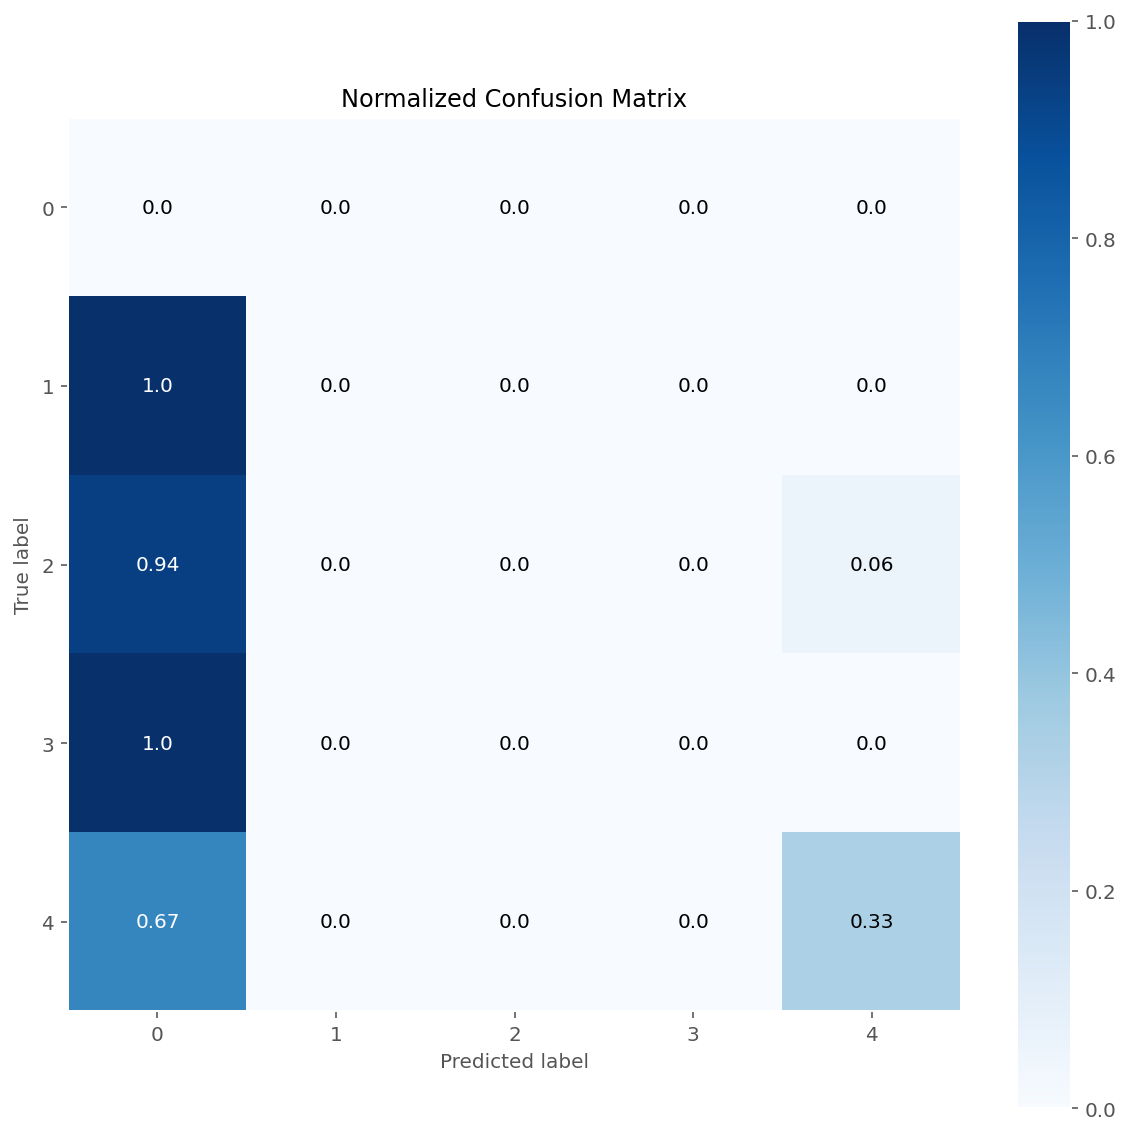

In [398]:
# We can visualise the new predictions in a confusion matrix (0 is not a class 4 salary, 4 is a class 4 salary)
# We can see much less values are predicted as class 4 now (compared to above)
skplt.metrics.plot_confusion_matrix(y_test_vec, Y_pp['new threshold classification 4'], normalize=True, figsize=(10,10))
plt.show()

In [760]:
# However we really need to try and formulate a way of changing multiple thresholds i.e. for each class,
# so it is easier to classify say class 1 and 2 and more difficult to class 3 and 4, giving more weight to 
# the lesser salaries.

def predict_proba(self, x, threshold_list=None):
    # get origin probability
    ori_proba = self.predict_proba(x)
    
    # set default threshold
    if threshold_list is None:
        threshold_list = np.full(ori_proba[0].shape, 1)

    # get the output shape of threshold_list
    output_shape = np.array(threshold_list).shape

    # element-wise divide by the threshold of each classes
    new_proba = np.divide(ori_proba, threshold_list)

    # calculate the norm (sum of new probability of each classes)
    norm = np.linalg.norm(new_proba, ord=1, axis=1)

    # reshape the norm
    norm = np.broadcast_to(np.array([norm]).T, (norm.shape[0],output_shape[0]))

    # renormalize the new probability
    new_proba = np.divide(new_proba, norm)

    return new_proba

def predict(self, x, threshold_list=None):
    return np.argmax(self.predict_proba(x, threshold_list), axis=1)

In [761]:
# Here I'm choosing to reduce the threshold to 0.2 for class 1 and 3 and increased threshold to 0.3 for class 3 and 4
predict_proba(lr_gs_vect.best_estimator_, X_test_vec, (0.2, 0.2, 0.3, 0.3))

array([[7.28202207e-01, 1.68937727e-01, 1.02860066e-01, 2.95914593e-11],
       [1.79439632e-02, 2.41209598e-01, 7.40451821e-01, 3.94618217e-04],
       [7.33161790e-02, 1.39634222e-01, 1.23924238e-01, 6.63125361e-01],
       [2.49890575e-02, 1.14796340e-01, 1.04124097e-01, 7.56090505e-01],
       [2.42132307e-03, 1.20787912e-01, 1.73178700e-01, 7.03612064e-01],
       [1.59352986e-01, 2.21232664e-01, 7.89554144e-02, 5.40458936e-01],
       [5.98930331e-03, 2.56897588e-01, 1.02365074e-01, 6.34748035e-01],
       [4.67298343e-02, 6.31454102e-01, 3.21804042e-01, 1.20217679e-05],
       [5.18989263e-01, 2.74800678e-01, 2.06210059e-01, 2.78095829e-15],
       [1.17017330e-01, 7.03598104e-02, 1.21178768e-01, 6.91444091e-01],
       [1.84298226e-02, 2.66479008e-01, 7.15091098e-01, 7.10801080e-08],
       [6.47505693e-02, 7.13826754e-01, 2.21422613e-01, 6.41290504e-08],
       [6.74044213e-04, 6.42363629e-01, 3.56957419e-01, 4.90737714e-06],
       [2.68249577e-02, 1.56351920e-01, 6.95382206e

In [762]:
# Now we can see the new predicted probabilities with the changed thresholds
Y_ppp = pd.DataFrame(predict_proba(lr_gs_vect.best_estimator_, X_test_vec, (0.2, 0.2, 0.3, 0.3)), 
                    columns=['minimum to 25% percentile salaries', '25% percentile to median salaries', 'median to 75% percentile salaries', '75% percentile to maximum salaries'])
Y_ppp

minimum to 25% percentile salaries  25% percentile to median salaries  \
0                              0.728202                           0.168938   
1                              0.017944                           0.241210   
2                              0.073316                           0.139634   
3                              0.024989                           0.114796   
4                              0.002421                           0.120788   
5                              0.159353                           0.221233   
6                              0.005989                           0.256898   
7                              0.046730                           0.631454   
8                              0.518989                           0.274801   
9                              0.117017                           0.070360   
10                             0.018430                           0.266479   
11                             0.064751                           0.713827   
12                             0.000674                           0.642364   
13                             0.026825                           0.156352   
14                             0.791295                           0.098334   
15                             0.740035                           0.129802   
16                             0.493131                           0.394051   
17                             0.248173                           0.427411   
18                             0.100291                           0.503714   
19                             0.512866                           0.228507   
20                             0.000846                           0.051377   
21                             0.796239                           0.098602   
22                             0.720682                           0.236395   
23                             0.015769                           0.476150   
24                             0.018812                           0.204486   
25                             0.324253                           0.466811   
26                             0.410646                           0.466258   
27                             0.018641                           0.205697   
28                             0.124331                           0.174947   
29                             0.219159                           0.551229   
30                             0.650946                           0.187572   
31                             0.092974                           0.590001   
32                             0.001791                           0.557477   
33                             0.027854                           0.599912   
34                             0.002881                           0.143656   
35                             0.137889                           0.070630   
36                             0.019600                           0.753228   
37                             0.034400                           0.336418   
38                             0.003746                           0.387724   
39                             0.722053                           0.175763   
40                             0.003795                           0.171165   
41                             0.822007                           0.139260   
42                             0.694912                           0.211153   
43                             0.385082                           0.438948   
44                             0.000432                           0.113023   
45                             0.002150                           0.317622   
46                             0.137417                           0.743682   
47                             0.025812                           0.422407   
48                             0.070222                           0.714336   
49                             0.066995                           0.704907   
50                         

In [757]:
# we can now see the mean values for the categories have shifted
# likelihood of predicting minimum to 25% percentile salaries has increased
# likelihood of predicting 25% percentile to median salaries has increased
# likelihood of predicting median to 75% percentile salaries has decreased
# likelihood of predicting 75% percentile to maximum salaries has decreased
Y_ppp.describe()

minimum to 25% percentile salaries  25% percentile to median salaries  \
count                          128.000000                         128.000000   
mean                             0.236941                           0.350196   
std                              0.279751                           0.219089   
min                              0.000004                           0.032824   
25%                              0.018588                           0.157738   
50%                              0.090507                           0.296587   
75%                              0.412653                           0.507637   
max                              0.836133                           0.838115   

       median to 75% percentile salaries  75% percentile to maximum salaries  
count                         128.000000                        1.280000e+02  
mean                            0.252611                        1.602517e-01  
std                             0.200576                        2.689890e-01  
min                             0.021424                        9.406090e-20  
25%                             0.111659                        5.805806e-10  
50%                             0.203224                        2.186619e-05  
75%                             0.305522                        2.590359e-01  
max                             0.908187                        7.560905e-01

In [ ]:
# Our new curve (after adjustments have been made on the thresholds) are very slightly lower in class 1,
# higher in class 2, slightly lower in class 3 and lower in class 4. Meaning the increase in threshold for
# classes 3 and 4 have caused a decreased in precision and recall scores. Surprisingly you would expect both 
# class 1 and 2 to show an increase in precision in recall scores with the reduction in threshold, class 1 did
# increase by a very minimal amount

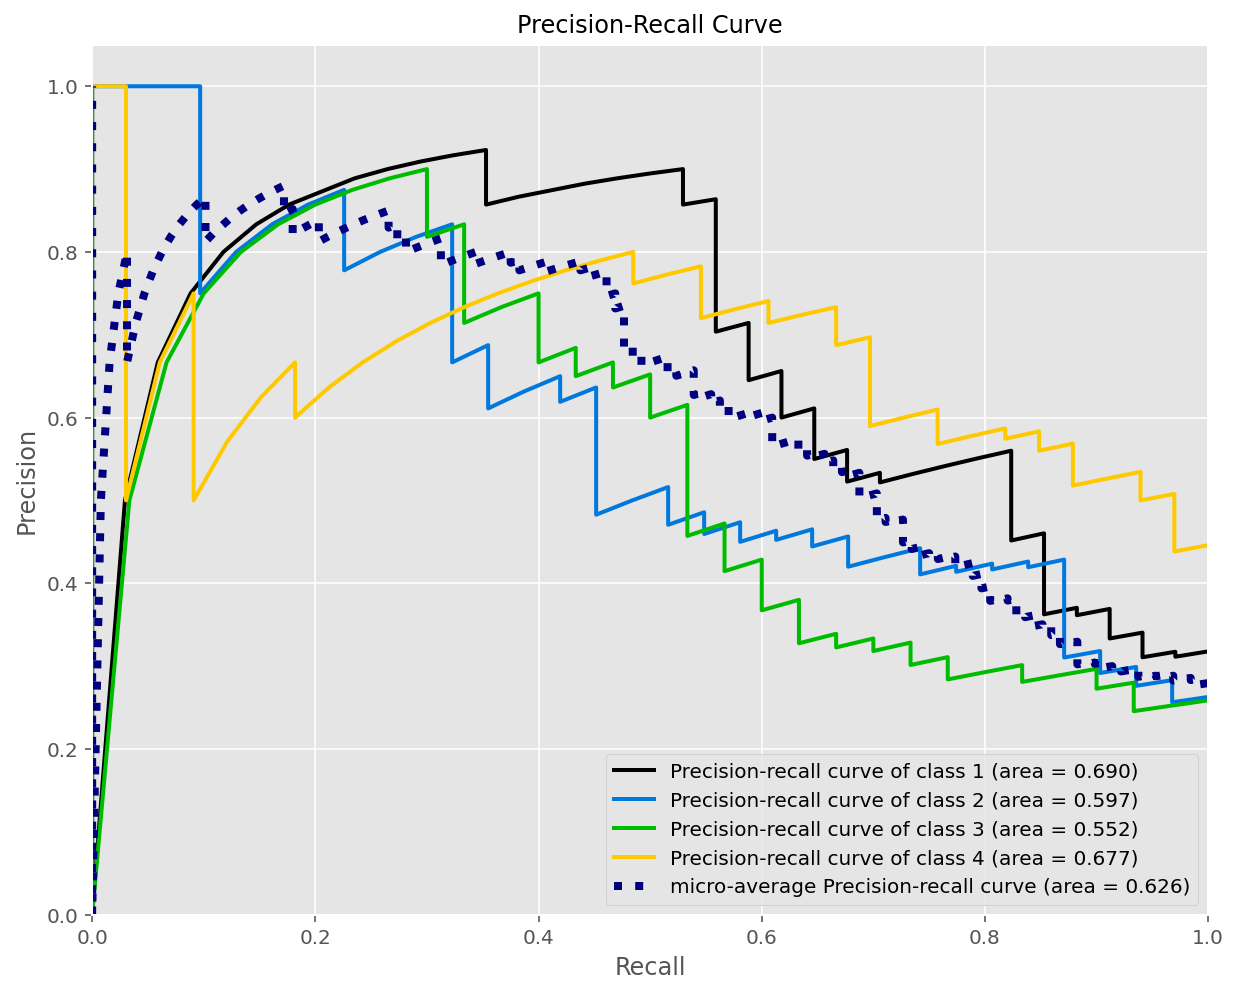

In [771]:
skplt.metrics.plot_precision_recall(y_test_vec, predict_proba(lr_gs_vect.best_estimator_, X_test_vec, (0.2, 0.2, 0.3, 0.3)), figsize=(10,8))
plt.show()

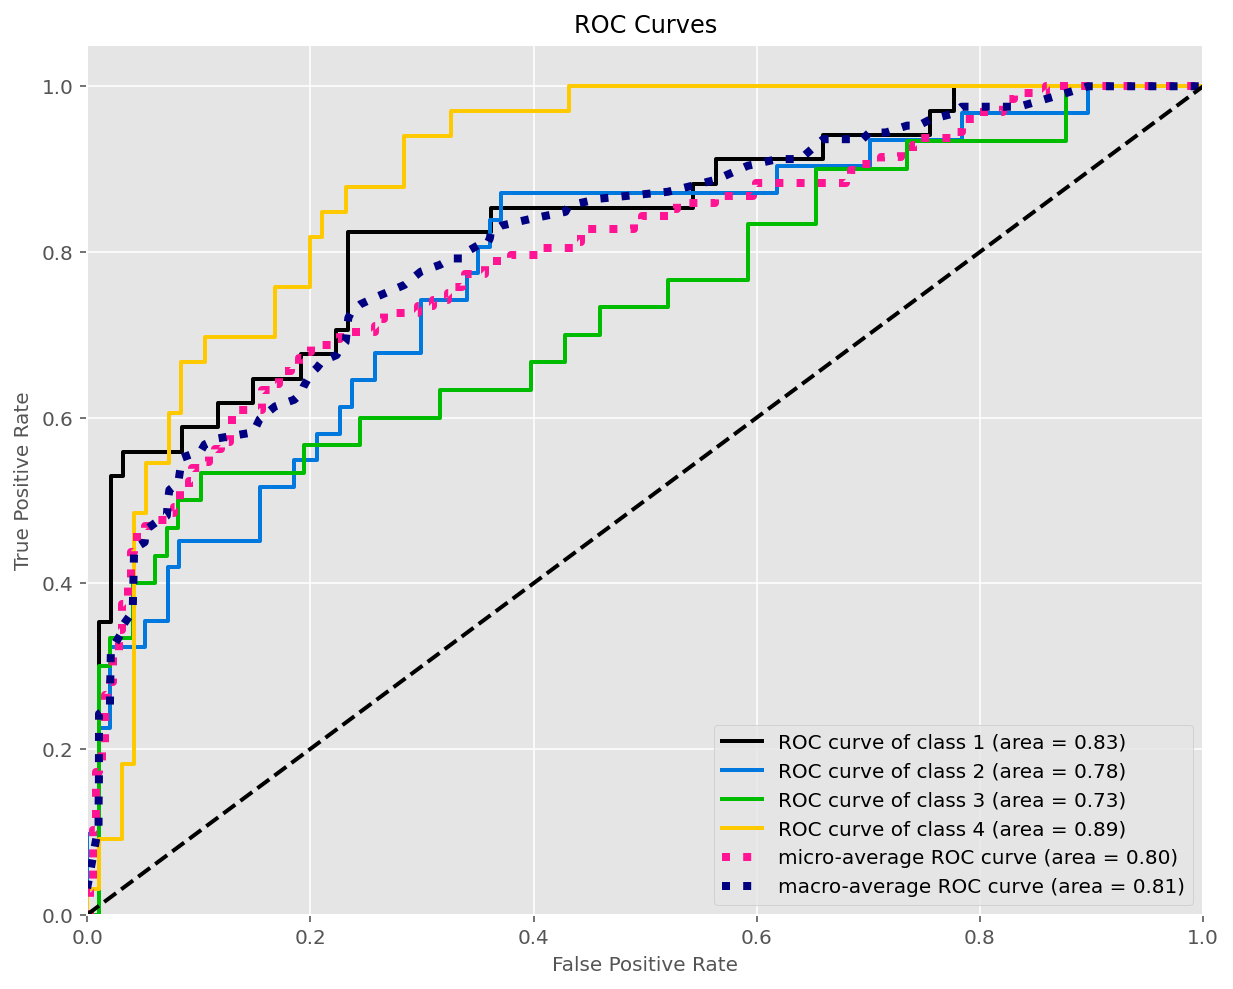

In [772]:
# We can see in the new ROC curve plotted below (after adjustments to the threshold) show a very small change
# in false positive and true positive predictions, class 1 slightly decreased, meaning a smaller AUC and a
# lesser result. Class 2, 3 and 4 stayed the same, meaning that eventhough we changed the threshold and received
# predictions more towards class 1 (the lower salaries) we did not reduce the AUC, maximising the true positive
# rate whilst minimizing the false positive rate.
skplt.metrics.plot_roc(y_test_vec, predict_proba(lr_gs_vect.best_estimator_, X_test_vec, (0.2, 0.2, 0.3, 0.3)), figsize=(10,8))
plt.show()

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [16]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.